# Library Imports and setup

In [1]:
## Imports
import csv
import numbers
import os
import random
import pickle
from collections import OrderedDict, defaultdict
from copy import deepcopy
from pathlib import Path
from typing import *

import flwr as fl
import ray
import gdown
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from flwr.common import Metrics, Config, GetPropertiesIns, GetPropertiesRes, MetricsAggregationFn
from flwr.common.parameter import ndarrays_to_parameters
from flwr.common.typing import NDArrays, Parameters, Scalar
from flwr.server import ServerConfig, Server
from flwr.server.client_manager import SimpleClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.criterion import Criterion
from flwr.server.strategy import FedAvgM as FedAvg
from PIL import Image
from PIL.Image import Image as ImageType
from torch.nn import Module
from torch.utils.data import DataLoader, Dataset, Subset
from torchvision import transforms
from tqdm import tqdm
from enum import IntEnum


# Add new seeds here for easy autocomplete
class Seeds(IntEnum):
    DEFAULT = 1337

np.random.seed(Seeds.DEFAULT)
random.seed(Seeds.DEFAULT)
torch.manual_seed(Seeds.DEFAULT)
torch.backends.cudnn.benchmark = False # type: ignore
torch.backends.cudnn.deterministic = True # type: ignore

def start_seeded_simulation(
    client_fn,
    num_clients,
    client_resources,
    server,
    config,
    strategy,
    seed: int = Seeds.DEFAULT,
):
    """Wrapper to always seed client selection."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    return fl.simulation.start_simulation(
        client_fn=client_fn,
        num_clients=num_clients,
        client_resources=client_resources,
        server=server,
        config=config,
        strategy=strategy,
    )

def fit_client_seeded(client, params, conf, seed=Seeds.DEFAULT, **kwargs):
    """Wrapper to always seed client training."""
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)
    return client.fit(params, conf, **kwargs)

PathType = Optional[Union[Path, str]]

def get_device() -> str:
    device = "cpu"
    if torch.cuda.is_available():
        device = "cuda"
    elif torch.backends.mps.is_available() and torch.backends.mps.is_built():
        device = "mps"
    return device

# File path setup

In [2]:
# home_dir = Path("/content")
home_dir = Path("/home/wash/LARGE/Work/L361_project/flower_fedbuff_project/FedBuffExperiments")
devices_info_dir: Path = home_dir / "device_info"
statistical_utility: Path = home_dir / "statistical_utility.csv"
dataset_dir: Path = home_dir / "femnist"
data_dir: Path = dataset_dir / "data"
centralized_partition: Path = dataset_dir / 'client_data_mappings' / 'centralized'
centralized_mapping: Path = dataset_dir / 'client_data_mappings' / 'centralized' / '0'
federated_partition: Path = dataset_dir / 'client_data_mappings' / 'fed_natural'

# Local imports

In [3]:
from client import FlowerRayClient, get_flower_client_generator
from client_manager import CustomClientManager
from strategy import FedAvgTraces
from client_utils import get_network_generator_cnn, get_model_parameters, aggregate_weighted_average, get_federated_evaluation_function,get_default_test_config, get_default_train_config

# System trace loading

In [4]:
def get_devices_info(
    root_dir: Path,
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """The function retrieves two pandas data frames containing
    traces and capabilities of clients' devices.

    Args:
        root_dir (Path): path to the folder containing such traces.

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: couple of dataframes containg the requeste info
    """    
    cbt_path = root_dir/'client_behave_trace'
    cdc_path = root_dir/'client_device_capacity'
    with open(cbt_path, 'rb') as f:
        client_behave_trace = pd.DataFrame(pickle.load(f)).transpose()
    with open(cdc_path, 'rb') as f:
        client_device_capacity = pd.DataFrame(pickle.load(f)).transpose()
    return client_behave_trace, client_device_capacity

def isActive(
    single_client_traces: Dict[str, Any],
    current_clock_time: int,
    ) -> bool:
    """The function returns a boolean describing whether the client is active or not.
    It returns True when `single_client_traces` are not given.
    The current (virtual) clock time must pass as a parameter.

    Args:
        single_client_traces (Dict[str, Any]): dictionary describing client device traces.
        current_clock_time (int): parameter that describes current (virtual) clock time.

    Returns:
        bool: True is the client is active, False elsewhere.
    """    
    # If no traces are given, return True
    if single_client_traces is None:
        return True
    # Get the normalized time when the `current_clock_time` is
    # greater than `single_client_traces['finish_time']`, nothing
    # happens if `current_clock_time` < `single_client_traces['finish_time']`
    normalized_time = current_clock_time % single_client_traces['finish_time']
    # Get the highest single_client_traces['active'] occurrence
    # that is lower than `normalized_time`
    single_client_traces['active'].sort()
    active_time = -1
    for t in single_client_traces['active']:
        active_time = t if t <= normalized_time else active_time
    # print(f"Highest active time: {active_time}")
    # Get the highest single_client_traces['inactive'] occurrence
    # that is lower than `normalized_time`
    single_client_traces['inactive'].sort()
    inactive_time = -1
    for t in single_client_traces['inactive']:
        inactive_time = t if t <= normalized_time else inactive_time
    # print(f"Highest inactive time: {inactive_time}")

    return active_time > inactive_time

def get_client_completion_time(
    single_client_device_capacity: Dict[str, Any],
    batch_size: int,
    n_batches: int,
    model_size: float,
    augmentation_factor: float = 3.0,
    model_size_scale_factor: float = 1.0
) -> Dict[str, float]:
    """The function computes the computation and communication latency of the client.
    These values are computed as follows:
    
    - Computation latency: `single_client_device_capacity['computation']` is the inference latency of models (ms/sample).
                            We compute the computation latency as the inference latency times the number of samples processed.
                            As reported in many papers, backwards-pass takes around 2x the latency, so we multiply it by 3x.
    - Communication latency: `single_client_device_capacity['communication']` represents the bandwidth of the device (kB/s).
                            We then compute the communication latency as the ratio between twice the size of the model and
                            the bandwidth of the device.
            
    Args:
        single_client_device_capacity (Dict[str, Any]): dictionary containing info about device capabilities.
        batch_size (int): batch size used during local client training.
        n_batches (int): number of batches trained by the client.
        model_size (float): an estimate of the size of the model in MB.
        augmentation_factor (float, optional): _description_. Defaults to 3.0.

    Returns:
        Dict[str, float]: dictionary containing estimates for time spent by the client in computation and communication.
    """
    return {'computation': augmentation_factor * batch_size * n_batches * float(single_client_device_capacity['computation'])/1000.,
            'communication': 2 * model_size_scale_factor * model_size * 1000 / float(single_client_device_capacity['communication'])}

client_behave_trace, client_device_capacity = get_devices_info(devices_info_dir)
# NOTE: setting random state does NOT make this return the same thing every run!
client_device_capacity = client_device_capacity.sample(len(client_behave_trace), replace=False, random_state=Seeds.DEFAULT)

# Simulating real devices using traces

## Sync Client

In [5]:
class FlowerRayClientTraces(FlowerRayClient):
    def __init__(
        self,
        cid: int,
        data_dir: Path,
        partition_dir: Path,
        model_generator: Callable[[], Module],
        single_client_device_capacity: Dict[str, Any],
        single_client_traces: Dict[str, Any],
        verbose: bool = False,
    ) -> None:
        """Function to initialise the client with its unique id
        and the directory from which it can load its data.
        Device capabilities and traces are also passed to the client.

        Args:
            data_dir (Path): path to the dataset folder.
            cid (int): Unique client id for a client used to map it to its data partition
            partition_dir (Path): The directory containing data for each client/client id
            model_generator (Callable[[], Module]): The model generator function
            single_client_device_capacity (Dict[str, Any]): dictionary containing info about device capabilities.
            single_client_traces (Dict[str, Any]): dictionary describing client device traces.
            verbose (bool): boolean describing whether the client should print or not.
        """
        super().__init__(cid, data_dir, partition_dir, model_generator)
        self.device_capacity = single_client_device_capacity
        self.trace = single_client_traces
        self.verbose = verbose
        self.properties: Dict[str, Scalar] = { # type: ignore
            "tensor_type": "numpy.ndarray",
            "cid": self.cid,
            "device_capacity": self.device_capacity,
            "traces": self.trace,
            }

    def fit(
        self, parameters: NDArrays, config: Dict[str, Scalar], **kwargs
    ) -> Tuple[NDArrays, int, dict]:
        """Function which receives and trains a model on the local client data using parameters from the config dict.
        Before training, the function checks if the client is active at the current time step.

        Args:
            net (NDArrays): Pytorch model parameters
            config (Dict[str, Scalar]): Dictionary describing the training parameters

        Returns:
            Tuple[NDArrays, int, dict]: Returns the updated model, the size of the local dataset and other metrics
        """

        # We need to include model size to compute communications costs
        # As part of our systems-aware simulation
        # Importantly, since Flower now accepts failures this will only cause the client to return a failure
        if "model_size" not in config:
            raise Exception("Model size not found in config")
        
        # We need to compute the number of samples in the training set
        # As such we set n_batches to the number of batches which the set contains
        completion_time = get_client_completion_time(
            single_client_device_capacity=self.device_capacity,
            batch_size=int(config['batch_size']),
            n_batches=int(int(config['epochs'])*self.get_train_set_size()/int(config['batch_size'])),
            model_size=float(config['model_size']),
        )
        # Add up the communication and computation times
        total_time = completion_time['communication']+completion_time['computation']

        # Store the result in the trace
        self.trace['duration'] = total_time

        if self.verbose:
            print(f"Client {self.cid} --- Current virtual clock time: {config['current_virtual_clock']}")
            print(f"Client {self.cid} --- Duration: {total_time}")
            print(f"Client {self.cid} --- Traces: {self.trace}")
            print(f"Client {self.cid} --- Predicted completion: {int(config['current_virtual_clock'])+int(total_time)}")
            print(f"Client {self.cid} --- isActive: {isActive(self.trace, int(config['current_virtual_clock'])+int(total_time))}")
        if "current_virtual_clock" not in config:
            raise Exception("Current virtual clock not found in config")
        if not isActive(self.trace, int(config["current_virtual_clock"])+int(total_time)):
            raise Exception(f"Client {self.cid} is not active at the current time step")
        
        params, n_samples, results = super().fit(parameters, config)
        results.update({
            "client_completion_time": total_time,
            "computation": self.device_capacity['computation'],
            "communication": self.device_capacity['communication'],
            "cid": self.cid,
        })
        return params, n_samples, results

    def evaluate(
        self, parameters: NDArrays, config: Dict[str, Scalar], **kwargs
    ) -> Tuple[float, int, dict]:
        """Function which receives and tests a model on the local client data using parameters from the config dict
        Before testing, the function checks if the client is active at the current time step.

        Args:
            net (NDArrays): Pytorch model parameters
            config (Dict[str, Scalar]): Dictionary describing the testing parameters

        Returns:
            Tuple[float, int, dict]: Returns the loss accumulate during testing, the size of the local dataset and other metrics such as accuracy
        """
        if "model_size" not in config:
            raise Exception("Model size not found in config")
        
        # Estimate time based on number of batches in dataset
        completion_time = get_client_completion_time(
            single_client_device_capacity=self.device_capacity,
            batch_size=int(config['batch_size']),
            n_batches=int(self.get_test_set_size()/int(config['batch_size'])),
            model_size=float(config['model_size']),
        )

        # Compute total time
        total_time = completion_time['communication']+completion_time['computation']

        # Store result in trace
        self.trace['duration'] = total_time
        if self.verbose:
            print(f"Client {self.cid} --- Current virtual clock time: {config['current_virtual_clock']}")
            print(f"Client {self.cid} --- Duration: {total_time}")
            print(f"Client {self.cid} --- Traces: {self.trace}")
            print(f"Client {self.cid} --- Predicted completion: {int(config['current_virtual_clock'])+int(total_time)}")
            print(f"Client {self.cid} --- isActive: {isActive(self.trace, int(config['current_virtual_clock'])+int(total_time))}")
        if "current_virtual_clock" not in config:
            raise Exception("Current virtual clock not found in config")
        if not isActive(self.trace, int(config["current_virtual_clock"])+int(total_time)):
            raise Exception(f"Client {self.cid} is not active at the current time step")
        
        loss, n_samples, results = super().evaluate(parameters, config)
        results.update({
            "client_completion_time": total_time,
            "computation": self.device_capacity['computation'],
            "communication": self.device_capacity['communication'],
            "cid": self.cid,
        })
        return loss, n_samples, results

## Sync Client generator

In [6]:
def get_flower_client_with_traces_generator(
    clients_device_capacity: List[Dict[str, Any]],
    clients_traces: List[Dict[str, Any]],
    model_generator: Callable[[], Module],
    data_dir: Path,
    partition_dir: Path,
    mapping_fn: Optional[Callable[[int], int]] = None, # IGNORED
) -> Callable[[str], FlowerRayClient]:
    """Wrapper function for the client instance generator.
    This provides the client generator with a model generator function.
    Also, the partition directory must be passed.
    A mapping function could be used for filtering/ordering clients.

    Args:
        clients_device_capacity (List[Dict[str, Any]]): list containing the clients device capabilities.
        clients_traces (List[Dict[str, Any]]): list containing the clients traces.
        data_dir (Path): path to the datasßet folder.
        model_generator (Callable[[], Module]): model generator function.
        partition_dir (Path): directory containing the partition.
        mapping_fn (Optional[Callable[[int], int]]): function mapping sorted/filtered ids to real cid.

    Returns:
        Callable[[str], FlowerRayClient]: client instance.
    """
    def client_fn(cid: str) -> FlowerRayClientTraces:
        """Creates a single client instance given the client id `cid`.

        Args:
            cid (str): client id, Flower requires this to of type str.

        Returns:
            FlowerRayClientTraces: client instance.
        """
        print(f"Getting client with id {cid}")
        client = FlowerRayClientTraces(
            # NOTE: passing the called `cid` here to allow for different mapping between data and devices
            single_client_device_capacity=clients_device_capacity[int(cid)],
            single_client_traces=clients_traces[int(cid)],
            # NOTE: the mapping is only applied here, this is due to control the data mapping
            cid=int(cid),
            data_dir=data_dir,
            partition_dir=partition_dir,
            model_generator=model_generator,
            # NOTE: you may want to comment out the following line or to set the verbosity to False
            verbose=True,
        )
        
        client.device = get_device()
        return client

    return client_fn

## Activity criterion

In [7]:
class ActivityCriterion(Criterion):
    """This class implements the Template criterion."""
    
    def __init__(self, client_traces) -> None:
        """Initializes the Template criterion."""
        self.current_virtual_clock = 0
        self.client_traces = client_traces
    
    def select(self, client: ClientProxy) -> bool:
        """Selects the client that receives if it is active.
        Before selecting it, the function gets the `properties` of the client.

        Args:
            client (ClientProxy): client proxy to select.

        Returns:
            bool: True if the client is selected, False otherwise.
        """        
        # request_properties: Config = {
        #     # Here goes the template of the client properties
        #     "tensor_type": "str",
        #     "cid": "str",
        #     "device_capacity": "Dict[str, Any]",
        #     "traces": "Dict[str, Any]",
        #     }
        # ins: GetPropertiesIns = GetPropertiesIns(
        #     config=request_properties
        # )
        # # This contains the client properties
        # value: GetPropertiesRes = client.get_properties(ins, timeout=None)
        # # NOTE: here we use `isActive` to check if the client is active at the current time step
        # return isActive(value.properties['traces'], self.current_virtual_clock) # type: ignore
        
        traces = self.client_traces[int(client.cid)]
        return isActive(traces, self.current_virtual_clock)

## Run the simulation

### Generators

In [8]:
get_default_test_config()

{'batch_size': 32, 'num_workers': 2}

In [9]:
torch.manual_seed(Seeds.DEFAULT)
network_generator_cnn = get_network_generator_cnn()
seed_net_cnn = network_generator_cnn()
seed_model_cnn_params: NDArrays = get_model_parameters(seed_net_cnn)

federated_evaluation_function = get_federated_evaluation_function(
    data_dir=data_dir,
    centralized_mapping=centralized_mapping,
    device=get_device(),
    batch_size=get_default_test_config()["batch_size"],
    num_workers=get_default_test_config()["num_workers"],
    model_generator=network_generator_cnn,
    criterion=nn.CrossEntropyLoss(),
)

# NOTE: we are using here the `get_flower_client_with_traces_generator`
num_total_clients = 3229
sampled_cdc = client_device_capacity.sample(num_total_clients, replace=False, random_state=Seeds.DEFAULT)
sampled_cbt = client_behave_trace.sample(num_total_clients, replace=False, random_state=Seeds.DEFAULT)

device_capacity_dict = sampled_cdc.to_dict('records')
behave_traces_dict = sampled_cbt.to_dict('records')

flower_client_with_traces_generator: Callable[
    [int], FlowerRayClientTraces
] = get_flower_client_with_traces_generator(
    clients_device_capacity=device_capacity_dict, # type: ignore
    clients_traces=behave_traces_dict, # type: ignore
    model_generator=network_generator_cnn,
    data_dir=data_dir,
    partition_dir=federated_partition) # type: ignore

## CONFIG OPTIONS

train_config = get_default_train_config()
train_config.update({
        "model_size": 1000,
        "current_virtual_clock": 0.0,
    })
test_config = get_default_test_config()
test_config.update({
        "model_size": 1000,
        "current_virtual_clock": 0.0,
    })

on_fit_config_fn: Callable[[int], Dict[str, Scalar]] = lambda cid: train_config
on_evaluate_config_fn: Callable[[int], Dict[str, Scalar]] = lambda cid: test_config # type: ignore

### FedAvg version

In [10]:
num_clients_per_round: int = 3
num_evaluate_clients: int = 1
fraction_fit: float = float(num_clients_per_round) / num_total_clients
# fraction_evaluate: float = float(num_evaluate_clients) / num_total_clients
fraction_evaluate: float = 0.0

accept_failures = True
min_fit_clients = 10
min_available_clients = 10
initial_parameters: Parameters = ndarrays_to_parameters(seed_model_cnn_params)
# maximum amount of resources that a client can take
client_resources = {
    "num_gpus": 1.0/2 if get_device() == 'cuda' else 0.0,
    "num_cpus": 1,
}

fedavg_strategy = FedAvgTraces(
    fraction_fit=fraction_fit,
    fraction_evaluate=fraction_evaluate,
    min_fit_clients=min_fit_clients,
    min_available_clients=min_available_clients,
    on_fit_config_fn=on_fit_config_fn,
    on_evaluate_config_fn=on_evaluate_config_fn,
    initial_parameters=initial_parameters,
    accept_failures=accept_failures,
    evaluate_fn=federated_evaluation_function,
    fit_metrics_aggregation_fn=aggregate_weighted_average,
    evaluate_metrics_aggregation_fn=aggregate_weighted_average,
)

criterion = ActivityCriterion(behave_traces_dict)
client_manager = CustomClientManager(criterion=criterion, seed=Seeds.DEFAULT)
sync_server = Server(
    client_manager=client_manager,
    strategy=fedavg_strategy,
    asynchronous=False,
)

In [11]:
sync_hist = start_seeded_simulation(
    client_fn=flower_client_with_traces_generator,
    num_clients=num_total_clients,
    client_resources=client_resources,
    server=sync_server,
    config=ServerConfig(num_rounds=10, asynchronous=False),
    strategy=fedavg_strategy,
)

230373 WARNING flwr 2023-03-21 23:44:26,845 | app.py:208 | Both server and strategy were provided, ignoring strategy
230373 INFO flwr 2023-03-21 23:44:26,846 | app.py:146 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None, asynchronous=False)
2023-03-21 23:44:29,041	INFO worker.py:1553 -- Started a local Ray instance.
230373 INFO flwr 2023-03-21 23:44:30,232 | app.py:180 | Flower VCE: Ray initialized with resources: {'object_store_memory': 1056768000.0, 'CPU': 8.0, 'node:10.9.7.124': 1.0, 'memory': 2113536000.0}
230373 INFO flwr 2023-03-21 23:44:30,251 | server.py:95 | Initializing global parameters
230373 INFO flwr 2023-03-21 23:44:30,251 | server.py:316 | Using initial parameters provided by strategy
230373 INFO flwr 2023-03-21 23:44:30,252 | server.py:97 | Evaluating initial parameters


Server round 0


100%|██████████| 891/891 [00:09<00:00, 97.41it/s] 
230373 INFO flwr 2023-03-21 23:44:39,417 | server.py:100 | initial parameters (loss, other metrics): 3686.0015926361084, {'accuracy': 0.005892669238863556, 'eval_time': 0.0}
230373 INFO flwr 2023-03-21 23:44:39,418 | server.py:110 | FL starting
230373 INFO flwr 2023-03-21 23:44:39,421 | client_manager.py:49 | Sampling using <__main__.ActivityCriterion object at 0x7f6eba6c5300>
230373 DEBUG flwr 2023-03-21 23:44:39,423 | server.py:255 | fit_round 1: strategy sampled 10 clients (out of 3229)


Sampled the following clients:  ['2907', '2338', '678', '447', '267', '1872', '2471', '2614', '2674', '70']


230373 DEBUG flwr 2023-03-21 23:44:45,097 | ray_client_proxy.py:87 | ray::launch_and_fit() (pid=230630, ip=10.9.7.124)
  File "/home/wash/LARGE/Work/L361_project/flower_fedbuff_project/src/py/flwr/simulation/ray_transport/ray_client_proxy.py", line 148, in launch_and_fit
    return maybe_call_fit(
  File "/home/wash/LARGE/Work/L361_project/flower_fedbuff_project/src/py/flwr/client/client.py", line 184, in maybe_call_fit
    return client.fit(fit_ins)
  File "/home/wash/LARGE/Work/L361_project/flower_fedbuff_project/src/py/flwr/client/app.py", line 275, in _fit
    results = self.numpy_client.fit(parameters, ins.config)  # type: ignore
  File "/tmp/ipykernel_230373/2728577686.py", line 79, in fit
Exception: Client 2338 is not active at the current time step
230373 DEBUG flwr 2023-03-21 23:44:45,110 | ray_client_proxy.py:87 | ray::launch_and_fit() (pid=230627, ip=10.9.7.124)
  File "/home/wash/LARGE/Work/L361_project/flower_fedbuff_project/src/py/flwr/simulation/ray_transport/ray_client_

(launch_and_fit pid=230624) Getting client with id 2471
(launch_and_fit pid=230624) Client 2471 --- Current virtual clock time: 0.0
(launch_and_fit pid=230624) Client 2471 --- Duration: 967.1871108575064
(launch_and_fit pid=230624) Client 2471 --- Traces: {'duration': 967.1871108575064, 'inactive': [44658, 57639, 124793, 177492, 253068], 'finish_time': 259200, 'active': [0, 55446, 88526, 166394, 251903], 'model': 'SM-G610F'}
(launch_and_fit pid=230624) Client 2471 --- Predicted completion: 967
(launch_and_fit pid=230624) Client 2471 --- isActive: True
(launch_and_fit pid=230629) Getting client with id 70
(launch_and_fit pid=230629) Client 70 --- Current virtual clock time: 0.0
(launch_and_fit pid=230629) Client 70 --- Duration: 1448.678877762347
(launch_and_fit pid=230629) Client 70 --- Traces: {'duration': 1448.678877762347, 'inactive': [314, 6902, 10071, 10187, 10447, 10636, 10857, 69622, 75695, 90861, 170800, 170920, 234779, 251422, 251448, 251521, 251524, 251652, 251754, 251822, 25

  0%|          | 0/8 [00:00<?, ?it/s] 


(launch_and_fit pid=231071) Getting client with id 2614
(launch_and_fit pid=231071) Client 2614 --- Current virtual clock time: 0.0
(launch_and_fit pid=231071) Client 2614 --- Duration: 1391.952242700838
(launch_and_fit pid=231071) Client 2614 --- Traces: {'duration': 1391.952242700838, 'inactive': [26014, 46429, 46578, 46591, 46620, 46916, 46971, 46995, 47499, 48417, 54946, 155946, 160975, 202825, 212756, 236786, 244106, 246873, 344382, 371206, 400867, 409869, 410698, 416247, 431719], 'finish_time': 432000, 'active': [0, 46363, 46429, 46585, 46605, 46621, 46922, 46974, 47008, 47512, 48418, 147356, 158569, 172022, 204542, 230144, 240666, 244196, 255907, 368354, 392887, 407552, 410120, 413035, 425523], 'model': 'ROBBY2'}
(launch_and_fit pid=231071) Client 2614 --- Predicted completion: 1391
(launch_and_fit pid=231071) Client 2614 --- isActive: True
(launch_and_fit pid=231062) Getting client with id 2674
(launch_and_fit pid=231062) Client 2674 --- Current virtual clock time: 0.0
(launch_

 88%|████████▊ | 7/8 [00:01<00:00,  5.58it/s]
230373 DEBUG flwr 2023-03-21 23:44:54,417 | server.py:279 | fit_round 1 received 7 results and 3 failures
230373 INFO flwr 2023-03-21 23:44:54,418 | strategy.py:186 | Completion times of clients: [967.1871108575064, 1391.952242700838, 160.747556474767, 653.9093580981513, 511.7667562372511, 1087.5163560740814, 748.0411889634006]
230373 INFO flwr 2023-03-21 23:44:54,419 | strategy.py:188 | Maximum completion time of clients: 1391.952242700838


Server round 1


100%|██████████| 891/891 [00:11<00:00, 78.75it/s]
230373 INFO flwr 2023-03-21 23:45:05,764 | server.py:140 | fit progress: (1, 3411.923886537552, {'accuracy': 0.07969133637320239, 'eval_time': 1391.952242700838}, 26.34503716799918)
230373 INFO flwr 2023-03-21 23:45:05,764 | server.py:190 | evaluate_round 1: no clients selected, cancel
230373 INFO flwr 2023-03-21 23:45:05,775 | client_manager.py:49 | Sampling using <__main__.ActivityCriterion object at 0x7f6eba6c5300>
230373 DEBUG flwr 2023-03-21 23:45:05,777 | server.py:255 | fit_round 2: strategy sampled 10 clients (out of 3229)


Sampled the following clients:  ['75', '796', '2035', '2040', '2902', '2962', '2258', '1462', '1075', '2957']


  0%|          | 0/8 [00:00<?, ?it/s] 
230373 DEBUG flwr 2023-03-21 23:45:11,356 | ray_client_proxy.py:87 | ray::launch_and_fit() (pid=234588, ip=10.9.7.124)
  File "/home/wash/LARGE/Work/L361_project/flower_fedbuff_project/src/py/flwr/simulation/ray_transport/ray_client_proxy.py", line 148, in launch_and_fit
    return maybe_call_fit(
  File "/home/wash/LARGE/Work/L361_project/flower_fedbuff_project/src/py/flwr/client/client.py", line 184, in maybe_call_fit
    return client.fit(fit_ins)
  File "/home/wash/LARGE/Work/L361_project/flower_fedbuff_project/src/py/flwr/client/app.py", line 275, in _fit
    results = self.numpy_client.fit(parameters, ins.config)  # type: ignore
  File "/tmp/ipykernel_230373/2728577686.py", line 79, in fit
Exception: Client 1462 is not active at the current time step


(launch_and_fit pid=234585) Getting client with id 796
(launch_and_fit pid=234585) Client 796 --- Current virtual clock time: 1391.952242700838
(launch_and_fit pid=234585) Client 796 --- Duration: 296.5387975793243
(launch_and_fit pid=234585) Client 796 --- Traces: {'duration': 296.5387975793243, 'inactive': [7601, 131684], 'finish_time': 172800, 'active': [0, 97798], 'model': 'SM-A705F'}
(launch_and_fit pid=234585) Client 796 --- Predicted completion: 1687
(launch_and_fit pid=234585) Client 796 --- isActive: True
(launch_and_fit pid=234588) Getting client with id 1462
(launch_and_fit pid=234588) Client 1462 --- Current virtual clock time: 1391.952242700838
(launch_and_fit pid=234588) Client 1462 --- Duration: 1599.9649468094608
(launch_and_fit pid=234588) Client 1462 --- Traces: {'duration': 1599.9649468094608, 'inactive': [343, 1567, 20080, 20897, 24862, 88888, 89994, 90148, 90320, 90464, 91484, 92283, 130646, 130771, 130945, 132158, 132253, 132267, 132584, 132621, 132647, 132735, 13

  0%|          | 0/8 [00:00<?, ?it/s] 


(launch_and_fit pid=234577) Getting client with id 75
(launch_and_fit pid=234577) Client 75 --- Current virtual clock time: 1391.952242700838
(launch_and_fit pid=234577) Client 75 --- Duration: 2934.0096853169944
(launch_and_fit pid=234577) Client 75 --- Traces: {'duration': 2934.0096853169944, 'inactive': [26767, 122875, 124635, 139918, 217724, 285544], 'finish_time': 345600, 'active': [0, 112589, 123592, 125226, 213519, 263533], 'model': 'vivo 1904'}
(launch_and_fit pid=234577) Client 75 --- Predicted completion: 4325
(launch_and_fit pid=234577) Client 75 --- isActive: True
(launch_and_fit pid=234580) Getting client with id 2035
(launch_and_fit pid=234583) Getting client with id 2040
(launch_and_fit pid=234583) Client 2040 --- Current virtual clock time: 1391.952242700838
(launch_and_fit pid=234583) Client 2040 --- Duration: 1049.8973331279187
(launch_and_fit pid=234583) Client 2040 --- Traces: {'duration': 1049.8973331279187, 'inactive': [881, 931, 2042, 5740, 8018, 8577, 9491, 1000

  0%|          | 0/8 [00:00<?, ?it/s] 


(launch_and_fit pid=234586) Getting client with id 2962
(launch_and_fit pid=234586) Client 2962 --- Current virtual clock time: 1391.952242700838
(launch_and_fit pid=234586) Client 2962 --- Duration: 137.58885831410655
(launch_and_fit pid=234586) Client 2962 --- Traces: {'duration': 137.58885831410655, 'inactive': [15290], 'finish_time': 86400, 'active': [671], 'model': 'Lenovo TB-7304I'}
(launch_and_fit pid=234586) Client 2962 --- Predicted completion: 1528
(launch_and_fit pid=234586) Client 2962 --- isActive: True


  0%|          | 0/8 [00:00<?, ?it/s] 


(launch_and_fit pid=234633) Getting client with id 1075
(launch_and_fit pid=234633) Client 1075 --- Current virtual clock time: 1391.952242700838
(launch_and_fit pid=234633) Client 1075 --- Duration: 446.4704257051686
(launch_and_fit pid=234633) Client 1075 --- Traces: {'duration': 446.4704257051686, 'inactive': [205, 2521, 16597, 34432, 35295, 35821, 43411, 44953, 63531], 'finish_time': 86400, 'active': [204, 238, 9502, 34363, 34472, 35589, 42756, 43440, 61431], 'model': 'Infinix X653C'}
(launch_and_fit pid=234633) Client 1075 --- Predicted completion: 1837
(launch_and_fit pid=234633) Client 1075 --- isActive: True


100%|██████████| 8/8 [00:05<00:00,  1.47it/s]
230373 DEBUG flwr 2023-03-21 23:45:19,622 | ray_client_proxy.py:87 | ray::launch_and_fit() (pid=234986, ip=10.9.7.124)
  File "/home/wash/LARGE/Work/L361_project/flower_fedbuff_project/src/py/flwr/simulation/ray_transport/ray_client_proxy.py", line 148, in launch_and_fit
    return maybe_call_fit(
  File "/home/wash/LARGE/Work/L361_project/flower_fedbuff_project/src/py/flwr/client/client.py", line 184, in maybe_call_fit
    return client.fit(fit_ins)
  File "/home/wash/LARGE/Work/L361_project/flower_fedbuff_project/src/py/flwr/client/app.py", line 275, in _fit
    results = self.numpy_client.fit(parameters, ins.config)  # type: ignore
  File "/tmp/ipykernel_230373/2728577686.py", line 79, in fit
Exception: Client 2258 is not active at the current time step


(launch_and_fit pid=234986) Getting client with id 2258
(launch_and_fit pid=234986) Client 2258 --- Current virtual clock time: 1391.952242700838
(launch_and_fit pid=234986) Client 2258 --- Duration: 1032.0027001792835
(launch_and_fit pid=234986) Client 2258 --- Traces: {'duration': 1032.0027001792835, 'inactive': [1448, 25501, 26440, 28876, 28959, 29006, 29692, 30436, 35161, 52643, 65757, 80895, 84544, 112342, 116559, 120661, 137605, 152293, 197680, 206900, 244717, 248771, 298789, 338819, 389099, 399835, 407219, 410746, 413724], 'finish_time': 432000, 'active': [0, 23776, 25502, 28817, 28881, 28969, 29683, 29798, 34320, 45288, 60919, 80833, 80916, 111009, 113162, 116604, 133418, 148482, 192549, 204597, 241414, 247697, 295067, 323990, 382386, 398219, 407166, 407230, 412855], 'model': 'vivo 1819'}
(launch_and_fit pid=234986) Client 2258 --- Predicted completion: 2423
(launch_and_fit pid=234986) Client 2258 --- isActive: False


230373 DEBUG flwr 2023-03-21 23:45:20,405 | ray_client_proxy.py:87 | ray::launch_and_fit() (pid=237606, ip=10.9.7.124)
  File "/home/wash/LARGE/Work/L361_project/flower_fedbuff_project/src/py/flwr/simulation/ray_transport/ray_client_proxy.py", line 148, in launch_and_fit
    return maybe_call_fit(
  File "/home/wash/LARGE/Work/L361_project/flower_fedbuff_project/src/py/flwr/client/client.py", line 184, in maybe_call_fit
    return client.fit(fit_ins)
  File "/home/wash/LARGE/Work/L361_project/flower_fedbuff_project/src/py/flwr/client/app.py", line 275, in _fit
    results = self.numpy_client.fit(parameters, ins.config)  # type: ignore
  File "/tmp/ipykernel_230373/2728577686.py", line 79, in fit
Exception: Client 2957 is not active at the current time step
230373 DEBUG flwr 2023-03-21 23:45:20,408 | server.py:279 | fit_round 2 received 7 results and 3 failures
230373 INFO flwr 2023-03-21 23:45:20,408 | strategy.py:186 | Completion times of clients: [446.4704257051686, 296.5387975793243

Server round 2


  0%|          | 2/891 [00:00<00:52, 17.08it/s]

(launch_and_fit pid=237606) Getting client with id 2957
(launch_and_fit pid=237606) Client 2957 --- Current virtual clock time: 1391.952242700838
(launch_and_fit pid=237606) Client 2957 --- Duration: 713.5324543804035
(launch_and_fit pid=237606) Client 2957 --- Traces: {'duration': 713.5324543804035, 'inactive': [1076, 1420, 2162, 2466, 15408, 15631, 15803, 16715, 16895, 17122, 17238, 18803, 34816, 41559, 45154, 45584, 87177, 87287, 87307, 87827, 95200, 114768, 116395, 116845, 118366, 121295, 121530, 122032, 122120, 122145, 122358, 171184, 171443, 173296, 173919, 181763, 192028, 192066, 192751, 193906, 208601, 208642, 208644, 209004, 209130, 209645, 209736, 210173, 210490, 210566], 'finish_time': 259200, 'active': [0, 1077, 1420, 2163, 13740, 15409, 15635, 15803, 16715, 16896, 17122, 18800, 33854, 41148, 44556, 45533, 86303, 87178, 87287, 87307, 92558, 114341, 114768, 116843, 118291, 119945, 121298, 121532, 122034, 122121, 122145, 170931, 171257, 171444, 173297, 179377, 191880, 192040,

100%|██████████| 891/891 [00:08<00:00, 105.65it/s]
230373 INFO flwr 2023-03-21 23:45:28,862 | server.py:140 | fit progress: (2, 3113.9878916740417, {'accuracy': 0.08025254296737987, 'eval_time': 4325.961928017832}, 49.44390990299871)
230373 INFO flwr 2023-03-21 23:45:28,863 | server.py:190 | evaluate_round 2: no clients selected, cancel
230373 INFO flwr 2023-03-21 23:45:28,870 | client_manager.py:49 | Sampling using <__main__.ActivityCriterion object at 0x7f6eba6c5300>
230373 DEBUG flwr 2023-03-21 23:45:28,871 | server.py:255 | fit_round 3: strategy sampled 10 clients (out of 3229)


Sampled the following clients:  ['2517', '2988', '2483', '529', '808', '934', '3098', '2853', '1150', '925']
(launch_and_fit pid=238491) Getting client with id 2483
(launch_and_fit pid=238491) Client 2483 --- Current virtual clock time: 4325.961928017832
(launch_and_fit pid=238491) Client 2483 --- Duration: 310.00056840765023
(launch_and_fit pid=238491) Client 2483 --- Traces: {'duration': 310.00056840765023, 'inactive': [5915, 52414, 79412, 143652, 168531, 168625, 271346, 284884, 291111, 339192, 339194, 340735, 341241, 343795], 'finish_time': 345600, 'active': [1910, 8919, 78596, 87465, 168508, 168575, 268547, 274825, 285816, 338818, 339193, 339686, 340890, 341495], 'model': 'SM-G9600'}
(launch_and_fit pid=238491) Client 2483 --- Predicted completion: 4635
(launch_and_fit pid=238491) Client 2483 --- isActive: True


  0%|          | 0/8 [00:00<?, ?it/s] 


(launch_and_fit pid=238488) Getting client with id 2988
(launch_and_fit pid=238488) Client 2988 --- Current virtual clock time: 4325.961928017832
(launch_and_fit pid=238488) Client 2988 --- Duration: 674.7452167252973
(launch_and_fit pid=238488) Client 2988 --- Traces: {'duration': 674.7452167252973, 'inactive': [1, 179, 9794, 20301, 20402, 20419, 20461, 20480, 20499, 20522, 20606, 20626, 20653, 20683, 20706, 20740, 20763, 20786, 20820, 20835, 20858, 20875, 20902, 20924, 20952, 20988, 21009, 21026, 21045, 21064, 21081, 21097, 21123, 21141, 21162, 21180, 21204, 21232, 21260, 21278, 21296, 21316, 21335, 21356, 21371, 21391, 21413, 21431, 21452, 21469, 21492, 21509, 21526, 21549, 21567, 21585, 21594, 127760, 131310, 131350, 131462, 131489, 131539, 131556, 131579, 131619, 131645, 131664, 131681, 131699, 131723, 131753, 131766, 132096, 132115, 132140, 132170, 132197, 132221, 132240, 132260, 132282, 132299, 132323, 206167, 206187, 206215, 206242, 206271, 206287, 206316, 206343, 206370, 20639

  0%|          | 0/8 [00:00<?, ?it/s] 


(launch_and_fit pid=238493) Getting client with id 529
(launch_and_fit pid=238494) Getting client with id 808
(launch_and_fit pid=238494) Client 808 --- Current virtual clock time: 4325.961928017832
(launch_and_fit pid=238494) Client 808 --- Duration: 481.106196547328
(launch_and_fit pid=238494) Client 808 --- Traces: {'duration': 481.106196547328, 'inactive': [1793, 1861, 1894, 2995, 3246, 3327, 3418, 3576, 5701, 8858, 18719, 18971, 114797, 116893, 120333, 175338, 178028, 190302, 191645, 224188, 243291, 282621, 339453, 339879, 341339], 'finish_time': 345600, 'active': [695, 1794, 1863, 2011, 2995, 3246, 3336, 3419, 3577, 7323, 10388, 18719, 114688, 114798, 116894, 175078, 175339, 189288, 190302, 220875, 224192, 276571, 336714, 339463, 339880], 'model': 'RMX1941'}
(launch_and_fit pid=238494) Client 808 --- Predicted completion: 4806
(launch_and_fit pid=238494) Client 808 --- isActive: True
(launch_and_fit pid=238495) Client 934 --- Current virtual clock time: 4325.961928017832
(launch_

 12%|█▎        | 1/8 [00:00<00:03,  1.76it/s]


(launch_and_fit pid=238541) Getting client with id 1150
(launch_and_fit pid=238541) Client 1150 --- Current virtual clock time: 4325.961928017832
(launch_and_fit pid=238541) Client 1150 --- Duration: 370.3212014721119
(launch_and_fit pid=238541) Client 1150 --- Traces: {'duration': 370.3212014721119, 'inactive': [44, 3700, 5538, 25213, 26681, 30289, 39516, 45213, 45282, 45362, 45471, 45647, 45903, 45922, 46262, 46458, 50130, 50233, 58537, 59956, 63756, 81459, 94185, 94226, 94279, 94394, 98804, 104846, 109836, 111307, 111998, 112025, 116885, 125344, 130723, 158471, 159969, 175428, 175433, 175525, 175988, 176495, 176562, 176640, 177700, 177826, 178233, 178498, 178538, 178559, 178710, 178819, 178829, 193278, 193306, 193393, 193525, 226826, 235399, 244240, 246421, 249340, 249504, 249821, 249869, 252675, 252989, 253450, 253566, 257821, 258093, 258149, 287521, 289820, 304691, 310746, 313154, 319692, 326586, 329326, 340313, 341130, 345247, 345364, 345948, 346637, 346689, 346898, 347223, 35351

100%|██████████| 8/8 [00:06<00:00,  1.18it/s]


(launch_and_fit pid=242035) Getting client with id 2853
(launch_and_fit pid=242035) Client 2853 --- Current virtual clock time: 4325.961928017832
(launch_and_fit pid=242035) Client 2853 --- Duration: 904.8614010515907
(launch_and_fit pid=242035) Client 2853 --- Traces: {'duration': 904.8614010515907, 'inactive': [32517, 57397, 136822, 215410, 253375, 256295, 256428, 256582, 256785, 287924, 378625, 400070, 429914, 488710, 488718, 509572], 'finish_time': 518400, 'active': [123, 50697, 118949, 205276, 250805, 255988, 256295, 256429, 256583, 256786, 348620, 379644, 420358, 466422, 488711, 507057], 'model': 'CPH1605'}
(launch_and_fit pid=242035) Client 2853 --- Predicted completion: 5229
(launch_and_fit pid=242035) Client 2853 --- isActive: True
(launch_and_fit pid=242130) Getting client with id 925
(launch_and_fit pid=242130) Client 925 --- Current virtual clock time: 4325.961928017832
(launch_and_fit pid=242130) Client 925 --- Duration: 525.7401592703895
(launch_and_fit pid=242130) Client

 88%|████████▊ | 7/8 [00:01<00:00,  5.14it/s]
230373 DEBUG flwr 2023-03-21 23:45:45,012 | server.py:279 | fit_round 3 received 10 results and 0 failures
230373 INFO flwr 2023-03-21 23:45:45,013 | strategy.py:186 | Completion times of clients: [481.106196547328, 563.474196547328, 310.00056840765023, 563.2674644510255, 525.7401592703895, 1690.0852507211205, 904.8614010515907, 244.82024872989444, 370.3212014721119, 674.7452167252973]
230373 INFO flwr 2023-03-21 23:45:45,014 | strategy.py:188 | Maximum completion time of clients: 1690.0852507211205


Server round 3


100%|██████████| 891/891 [00:08<00:00, 105.69it/s]
230373 INFO flwr 2023-03-21 23:45:53,479 | server.py:140 | fit progress: (3, 2809.639505624771, {'accuracy': 0.22430726061031217, 'eval_time': 6016.047178738952}, 74.0609689799985)
230373 INFO flwr 2023-03-21 23:45:53,481 | server.py:190 | evaluate_round 3: no clients selected, cancel
230373 INFO flwr 2023-03-21 23:45:53,489 | client_manager.py:49 | Sampling using <__main__.ActivityCriterion object at 0x7f6eba6c5300>
230373 DEBUG flwr 2023-03-21 23:45:53,490 | server.py:255 | fit_round 4: strategy sampled 10 clients (out of 3229)


Sampled the following clients:  ['144', '2040', '258', '2455', '2858', '1806', '1279', '522', '2100', '532']


  0%|          | 0/8 [00:00<?, ?it/s] 


(launch_and_fit pid=243799) Getting client with id 1806
(launch_and_fit pid=243799) Client 1806 --- Current virtual clock time: 6016.047178738952
(launch_and_fit pid=243799) Client 1806 --- Duration: 745.5440256950537
(launch_and_fit pid=243799) Client 1806 --- Traces: {'duration': 745.5440256950537, 'inactive': [6875, 43308, 82238, 89941, 98204, 101212, 102927, 144081, 162632, 181255, 182784, 207974, 213825, 234418, 244627, 263075, 265843, 279868, 293112, 328134, 375713, 401556, 404668, 436002, 438396, 473277, 511114, 517569], 'finish_time': 518400, 'active': [22, 34278, 79222, 88179, 95307, 98261, 101252, 139602, 158509, 179333, 181672, 207786, 209387, 232075, 240578, 262693, 263092, 279561, 280707, 323690, 349343, 398224, 401583, 432568, 436021, 468122, 507111, 511812], 'model': 'Redmi 7'}
(launch_and_fit pid=243799) Client 1806 --- Predicted completion: 6761
(launch_and_fit pid=243799) Client 1806 --- isActive: True


  0%|          | 0/8 [00:00<?, ?it/s] 


(launch_and_fit pid=243802) Getting client with id 144
(launch_and_fit pid=243802) Client 144 --- Current virtual clock time: 6016.047178738952
(launch_and_fit pid=243802) Client 144 --- Duration: 1246.9791941327182
(launch_and_fit pid=243802) Client 144 --- Traces: {'duration': 1246.9791941327182, 'inactive': [16010, 33818, 109690], 'finish_time': 172800, 'active': [2111, 33248, 89172], 'model': 'CPH1803'}
(launch_and_fit pid=243802) Client 144 --- Predicted completion: 7262
(launch_and_fit pid=243802) Client 144 --- isActive: True
(launch_and_fit pid=243806) Getting client with id 2858
(launch_and_fit pid=243806) Client 2858 --- Current virtual clock time: 6016.047178738952
(launch_and_fit pid=243806) Client 2858 --- Duration: 687.1078649236786
(launch_and_fit pid=243806) Client 2858 --- Traces: {'duration': 687.1078649236786, 'inactive': [17222, 43120, 68931, 113790, 248946], 'finish_time': 259200, 'active': [2094, 41214, 61876, 113751, 243424], 'model': 'vivo 1816'}
(launch_and_fit

  0%|          | 0/8 [00:00<?, ?it/s] 


(launch_and_fit pid=243800) Client 258 --- Current virtual clock time: 6016.047178738952
(launch_and_fit pid=243800) Client 258 --- Duration: 1253.7939268388125
(launch_and_fit pid=243800) Client 258 --- Traces: {'duration': 1253.7939268388125, 'inactive': [4296, 4869, 9166, 49462, 259526, 264413], 'finish_time': 345600, 'active': [3338, 4356, 4896, 19591, 257743, 263722], 'model': 'CPH1923'}
(launch_and_fit pid=243800) Client 258 --- Predicted completion: 7269
(launch_and_fit pid=243800) Client 258 --- isActive: True
(launch_and_fit pid=243804) Getting client with id 2455
(launch_and_fit pid=243804) Client 2455 --- Current virtual clock time: 6016.047178738952
(launch_and_fit pid=243804) Client 2455 --- Duration: 915.237395995364
(launch_and_fit pid=243804) Client 2455 --- Traces: {'duration': 915.237395995364, 'inactive': [21905, 88172, 89355, 116582, 194327, 261770, 310922, 370449, 398722, 459911, 464898, 464905, 501691, 502096, 506195, 506323, 506374, 507317], 'finish_time': 518400

  0%|          | 0/8 [00:00<?, ?it/s] 


(launch_and_fit pid=246972) Getting client with id 2100
(launch_and_fit pid=246972) Client 2100 --- Current virtual clock time: 6016.047178738952
(launch_and_fit pid=246972) Client 2100 --- Duration: 591.3416719152932
(launch_and_fit pid=246972) Client 2100 --- Traces: {'duration': 591.3416719152932, 'inactive': [4692, 38316, 69881, 77756, 80233, 97987, 135913, 164287, 209650, 241165, 248473, 251347], 'finish_time': 259200, 'active': [2306, 4791, 66425, 76943, 77773, 90561, 128914, 157925, 182272, 240262, 241219, 248478], 'model': 'Redmi S2'}
(launch_and_fit pid=246972) Client 2100 --- Predicted completion: 6607
(launch_and_fit pid=246972) Client 2100 --- isActive: True


 38%|███▊      | 3/8 [00:00<00:00,  7.96it/s]
230373 DEBUG flwr 2023-03-21 23:46:08,751 | ray_client_proxy.py:87 | ray::launch_and_fit() (pid=247535, ip=10.9.7.124)
  File "/home/wash/LARGE/Work/L361_project/flower_fedbuff_project/src/py/flwr/simulation/ray_transport/ray_client_proxy.py", line 148, in launch_and_fit
    return maybe_call_fit(
  File "/home/wash/LARGE/Work/L361_project/flower_fedbuff_project/src/py/flwr/client/client.py", line 184, in maybe_call_fit
    return client.fit(fit_ins)
  File "/home/wash/LARGE/Work/L361_project/flower_fedbuff_project/src/py/flwr/client/app.py", line 275, in _fit
    results = self.numpy_client.fit(parameters, ins.config)  # type: ignore
  File "/tmp/ipykernel_230373/2728577686.py", line 79, in fit
Exception: Client 532 is not active at the current time step
 50%|█████     | 4/8 [00:00<00:00,  8.16it/s]


(launch_and_fit pid=247535) Getting client with id 532
(launch_and_fit pid=247535) Client 532 --- Current virtual clock time: 6016.047178738952
(launch_and_fit pid=247535) Client 532 --- Duration: 1184.798153677758
(launch_and_fit pid=247535) Client 532 --- Traces: {'duration': 1184.798153677758, 'inactive': [6573, 25577, 83862, 152137, 171855, 172743, 172753, 179466, 211650, 252424, 315280, 401435, 402414, 403165, 404218, 426320], 'finish_time': 432000, 'active': [5067, 10417, 77352, 137336, 169903, 172213, 172743, 179429, 187376, 246617, 301731, 398957, 402220, 402415, 403166, 422424], 'model': 'CPH1801'}
(launch_and_fit pid=247535) Client 532 --- Predicted completion: 7200
(launch_and_fit pid=247535) Client 532 --- isActive: False


100%|██████████| 8/8 [00:00<00:00,  8.32it/s]
230373 DEBUG flwr 2023-03-21 23:46:09,297 | server.py:279 | fit_round 4 received 9 results and 1 failures
230373 INFO flwr 2023-03-21 23:46:09,299 | strategy.py:186 | Completion times of clients: [445.1495980246826, 1253.7939268388125, 745.5440256950537, 915.237395995364, 344.06996359302406, 591.3416719152932, 1246.9791941327182, 1049.8973331279187, 687.1078649236786]
230373 INFO flwr 2023-03-21 23:46:09,301 | strategy.py:188 | Maximum completion time of clients: 1253.7939268388125


Server round 4


100%|██████████| 891/891 [00:08<00:00, 106.48it/s]
230373 INFO flwr 2023-03-21 23:46:17,724 | server.py:140 | fit progress: (4, 2866.0170500278473, {'accuracy': 0.20024552788495265, 'eval_time': 7269.841105577765}, 98.30545776100007)
230373 INFO flwr 2023-03-21 23:46:17,725 | server.py:190 | evaluate_round 4: no clients selected, cancel
230373 INFO flwr 2023-03-21 23:46:17,735 | client_manager.py:49 | Sampling using <__main__.ActivityCriterion object at 0x7f6eba6c5300>
230373 DEBUG flwr 2023-03-21 23:46:17,736 | server.py:255 | fit_round 5: strategy sampled 10 clients (out of 3229)


Sampled the following clients:  ['2437', '402', '1691', '188', '1272', '800', '1319', '2233', '1555', '2882']


  0%|          | 0/8 [00:00<?, ?it/s] 


(launch_and_fit pid=248564) Getting client with id 2437
(launch_and_fit pid=248564) Client 2437 --- Current virtual clock time: 7269.841105577765
(launch_and_fit pid=248564) Client 2437 --- Duration: 530.464496115181
(launch_and_fit pid=248564) Client 2437 --- Traces: {'duration': 530.464496115181, 'inactive': [5051, 9507, 57858], 'finish_time': 86400, 'active': [3312, 5096, 19927], 'model': 'Moto C Plus'}
(launch_and_fit pid=248564) Client 2437 --- Predicted completion: 7799
(launch_and_fit pid=248564) Client 2437 --- isActive: True


  0%|          | 0/8 [00:00<?, ?it/s] 


(launch_and_fit pid=248567) Getting client with id 188
(launch_and_fit pid=248567) Client 188 --- Current virtual clock time: 7269.841105577765
(launch_and_fit pid=248567) Client 188 --- Duration: 1686.1347550691862
(launch_and_fit pid=248567) Client 188 --- Traces: {'duration': 1686.1347550691862, 'inactive': [8223, 10207, 15373, 15708, 28243, 30748, 34892, 38646, 74455, 93583, 95989, 106653, 109831, 113075, 114007, 114169, 114532, 114550, 116152, 118604, 155793, 172000, 172332, 177782, 185352, 261634, 270222, 275616, 292774, 293598, 293600, 293805, 313911, 313951, 313958, 323146, 340154, 342977, 343856, 351279, 368144, 371415, 372673, 374742, 383084, 410448, 420663, 420703, 422138, 422144, 424698, 428214], 'finish_time': 432000, 'active': [5585, 8231, 12749, 15373, 15727, 29607, 31090, 36880, 41809, 91252, 93594, 105699, 107303, 110353, 113397, 114007, 114245, 114536, 114556, 116153, 120533, 171362, 172049, 172333, 182123, 261326, 261643, 273807, 291386, 292774, 293598, 293791, 29380

 12%|█▎        | 1/8 [00:00<00:06,  1.14it/s]


(launch_and_fit pid=248574) Getting client with id 800
(launch_and_fit pid=248574) Client 800 --- Current virtual clock time: 7269.841105577765
(launch_and_fit pid=248574) Client 800 --- Duration: 1066.7956404363479
(launch_and_fit pid=248574) Client 800 --- Traces: {'duration': 1066.7956404363479, 'inactive': [32270, 118644, 164398, 203999, 250361, 338888, 377064, 414310, 426285, 463458, 503718], 'finish_time': 518400, 'active': [848, 88568, 160334, 169536, 246322, 330677, 344360, 413156, 417392, 431332, 497924], 'model': 'Redmi Note 5A'}
(launch_and_fit pid=248574) Client 800 --- Predicted completion: 8335
(launch_and_fit pid=248574) Client 800 --- isActive: True


 25%|██▌       | 2/8 [00:01<00:03,  1.87it/s]


(launch_and_fit pid=248623) Getting client with id 2233
(launch_and_fit pid=248623) Client 2233 --- Current virtual clock time: 7269.841105577765
(launch_and_fit pid=248623) Client 2233 --- Duration: 532.2844543804035
(launch_and_fit pid=248623) Client 2233 --- Traces: {'duration': 532.2844543804035, 'inactive': [1506, 1914, 27820, 56952, 68809, 69662, 69672, 109461, 142761, 144049, 144072, 147211, 147221, 168210], 'finish_time': 172800, 'active': [926, 1521, 1916, 51022, 66054, 68810, 69662, 72366, 142557, 143179, 144071, 146919, 147211, 147275], 'model': 'SM-G610F'}
(launch_and_fit pid=248623) Client 2233 --- Predicted completion: 7801
(launch_and_fit pid=248623) Client 2233 --- isActive: True


  0%|          | 0/8 [00:00<?, ?it/s] 


(launch_and_fit pid=251992) Getting client with id 1555
(launch_and_fit pid=251992) Client 1555 --- Current virtual clock time: 7269.841105577765
(launch_and_fit pid=251992) Client 1555 --- Duration: 605.1758600636174
(launch_and_fit pid=251992) Client 1555 --- Traces: {'duration': 605.1758600636174, 'inactive': [35341, 61059, 125985, 204303, 246325, 293357, 327437], 'finish_time': 345600, 'active': [3684, 55904, 96210, 175402, 242128, 268810, 322821], 'model': 'Redmi S2'}
(launch_and_fit pid=251992) Client 1555 --- Predicted completion: 7874
(launch_and_fit pid=251992) Client 1555 --- isActive: True
(launch_and_fit pid=252055) Getting client with id 2882
(launch_and_fit pid=252055) Client 2882 --- Current virtual clock time: 7269.841105577765
(launch_and_fit pid=252055) Client 2882 --- Duration: 320.0847594423552
(launch_and_fit pid=252055) Client 2882 --- Traces: {'duration': 320.0847594423552, 'inactive': [13166, 18573, 31005, 47641, 72907, 91514, 101719, 104995, 105018, 105507, 107

100%|██████████| 8/8 [00:01<00:00,  5.26it/s]
230373 DEBUG flwr 2023-03-21 23:46:35,978 | server.py:279 | fit_round 5 received 10 results and 0 failures
230373 INFO flwr 2023-03-21 23:46:35,979 | strategy.py:186 | Completion times of clients: [605.1758600636174, 1295.120629326178, 531.9845508660098, 532.2844543804035, 1686.1347550691862, 381.84604442963996, 602.8195448041901, 1066.7956404363479, 530.464496115181, 320.0847594423552]
230373 INFO flwr 2023-03-21 23:46:35,980 | strategy.py:188 | Maximum completion time of clients: 1686.1347550691862


Server round 5


100%|██████████| 891/891 [00:08<00:00, 100.47it/s]
230373 INFO flwr 2023-03-21 23:46:44,877 | server.py:140 | fit progress: (5, 2691.472757577896, {'accuracy': 0.3237811294282708, 'eval_time': 8955.975860646951}, 125.45843999299905)
230373 INFO flwr 2023-03-21 23:46:44,878 | server.py:190 | evaluate_round 5: no clients selected, cancel
230373 INFO flwr 2023-03-21 23:46:44,889 | client_manager.py:49 | Sampling using <__main__.ActivityCriterion object at 0x7f6eba6c5300>
230373 DEBUG flwr 2023-03-21 23:46:44,891 | server.py:255 | fit_round 6: strategy sampled 10 clients (out of 3229)


Sampled the following clients:  ['843', '2757', '2893', '2357', '386', '2256', '1647', '685', '104', '751']
(launch_and_fit pid=253849) Getting client with id 843
(launch_and_fit pid=253849) Client 843 --- Current virtual clock time: 8955.975860646951
(launch_and_fit pid=253849) Client 843 --- Duration: 1160.6477784499832
(launch_and_fit pid=253849) Client 843 --- Traces: {'duration': 1160.6477784499832, 'inactive': [5, 13899, 16286, 18836, 32454, 61471, 85404, 105373, 171542, 173268, 333867, 351204, 354897, 435228, 493461], 'finish_time': 518400, 'active': [0, 7726, 15904, 16905, 28659, 42001, 83510, 94334, 170859, 172717, 312112, 345086, 353588, 434133, 477221], 'model': 'POT-LX3'}
(launch_and_fit pid=253849) Client 843 --- Predicted completion: 10115
(launch_and_fit pid=253849) Client 843 --- isActive: True
(launch_and_fit pid=253851) Getting client with id 2757
(launch_and_fit pid=253851) Client 2757 --- Current virtual clock time: 8955.975860646951
(launch_and_fit pid=253851) Clie

  0%|          | 0/8 [00:00<?, ?it/s] 
230373 DEBUG flwr 2023-03-21 23:46:51,893 | ray_client_proxy.py:87 | ray::launch_and_fit() (pid=253858, ip=10.9.7.124)
  File "/home/wash/LARGE/Work/L361_project/flower_fedbuff_project/src/py/flwr/simulation/ray_transport/ray_client_proxy.py", line 148, in launch_and_fit
    return maybe_call_fit(
  File "/home/wash/LARGE/Work/L361_project/flower_fedbuff_project/src/py/flwr/client/client.py", line 184, in maybe_call_fit
    return client.fit(fit_ins)
  File "/home/wash/LARGE/Work/L361_project/flower_fedbuff_project/src/py/flwr/client/app.py", line 275, in _fit
    results = self.numpy_client.fit(parameters, ins.config)  # type: ignore
  File "/tmp/ipykernel_230373/2728577686.py", line 79, in fit
Exception: Client 685 is not active at the current time step


(launch_and_fit pid=253854) Getting client with id 2893
(launch_and_fit pid=253854) Client 2893 --- Current virtual clock time: 8955.975860646951
(launch_and_fit pid=253854) Client 2893 --- Duration: 951.0258110846362
(launch_and_fit pid=253854) Client 2893 --- Traces: {'duration': 951.0258110846362, 'inactive': [393, 28300, 116083, 174428, 174700, 177398, 206524, 207122, 208465, 215798, 245858, 245988, 246424, 247865, 249586, 251597, 264268, 298922, 305584, 331520, 331991, 333736, 337332, 348836, 373181], 'finish_time': 432000, 'active': [60, 399, 90742, 172057, 174429, 174701, 199912, 206651, 207128, 208473, 245715, 245859, 245989, 246425, 247866, 250433, 261607, 268525, 298925, 331225, 331527, 331995, 333754, 348699, 348838], 'model': 'Redmi Note 4'}
(launch_and_fit pid=253854) Client 2893 --- Predicted completion: 9906
(launch_and_fit pid=253854) Client 2893 --- isActive: True
(launch_and_fit pid=253855) Getting client with id 2357
(launch_and_fit pid=253855) Client 2357 --- Curren

 12%|█▎        | 1/8 [00:00<00:04,  1.46it/s]


(launch_and_fit pid=253859) Getting client with id 1647
(launch_and_fit pid=253859) Client 1647 --- Current virtual clock time: 8955.975860646951
(launch_and_fit pid=253859) Client 1647 --- Duration: 582.1631786715387
(launch_and_fit pid=253859) Client 1647 --- Traces: {'duration': 582.1631786715387, 'inactive': [9600, 24043, 24269, 24286, 24312, 24336, 26343, 26434, 27054, 30071, 59184, 59769, 59820, 59831, 60719, 61594, 61605, 73598, 83294, 86764, 93132, 94836, 99640, 99650, 103984, 109492, 148236, 164025, 165497, 169442, 178729, 185902, 191705, 198083, 231403, 234844, 249400, 260267, 260277, 269720, 276152, 278471, 281149, 282773, 285039, 337932, 340668, 346989, 348689, 355635, 355838, 356050, 356429, 359427, 366628, 366659, 367034, 367677, 367723, 404490, 408267, 440053, 450121, 450131, 486285, 494515, 510920, 512991], 'finish_time': 518400, 'active': [4488, 23688, 24044, 24270, 24295, 24313, 26244, 26407, 26435, 27069, 57501, 59184, 59770, 59821, 60164, 60720, 61595, 70480, 83127,

 12%|█▎        | 1/8 [00:01<00:07,  1.01s/it]
230373 DEBUG flwr 2023-03-21 23:46:52,995 | ray_client_proxy.py:87 | ray::launch_and_fit() (pid=253892, ip=10.9.7.124)
  File "/home/wash/LARGE/Work/L361_project/flower_fedbuff_project/src/py/flwr/simulation/ray_transport/ray_client_proxy.py", line 148, in launch_and_fit
    return maybe_call_fit(
  File "/home/wash/LARGE/Work/L361_project/flower_fedbuff_project/src/py/flwr/client/client.py", line 184, in maybe_call_fit
    return client.fit(fit_ins)
  File "/home/wash/LARGE/Work/L361_project/flower_fedbuff_project/src/py/flwr/client/app.py", line 275, in _fit
    results = self.numpy_client.fit(parameters, ins.config)  # type: ignore
  File "/tmp/ipykernel_230373/2728577686.py", line 79, in fit
Exception: Client 104 is not active at the current time step


(launch_and_fit pid=253892) Getting client with id 104
(launch_and_fit pid=253892) Client 104 --- Current virtual clock time: 8955.975860646951
(launch_and_fit pid=253892) Client 104 --- Duration: 1174.2966207779598
(launch_and_fit pid=253892) Client 104 --- Traces: {'duration': 1174.2966207779598, 'inactive': [9282, 47430, 47432, 67127, 74134, 95903, 134981, 149435, 153530, 176741, 190862, 220845, 239781, 256996, 264343, 329573, 354648, 393424, 418491, 444015, 449566, 479718, 492649], 'finish_time': 518400, 'active': [6633, 46128, 47430, 62730, 72812, 93397, 133369, 146529, 149439, 173309, 188340, 219929, 233711, 255118, 261482, 328191, 345049, 377432, 414645, 438585, 449052, 478048, 490275], 'model': 'Redmi Note 8'}
(launch_and_fit pid=253892) Client 104 --- Predicted completion: 10129
(launch_and_fit pid=253892) Client 104 --- isActive: False


  0%|          | 0/8 [00:00<?, ?it/s] 


(launch_and_fit pid=254426) Getting client with id 2256
(launch_and_fit pid=254426) Client 2256 --- Current virtual clock time: 8955.975860646951
(launch_and_fit pid=254426) Client 2256 --- Duration: 391.5441576570953
(launch_and_fit pid=254426) Client 2256 --- Traces: {'duration': 391.5441576570953, 'inactive': [13343, 105691, 230990, 455639, 484455], 'finish_time': 518400, 'active': [6815, 96750, 228916, 454431, 456736], 'model': 'CPH1803'}
(launch_and_fit pid=254426) Client 2256 --- Predicted completion: 9346
(launch_and_fit pid=254426) Client 2256 --- isActive: True


 62%|██████▎   | 5/8 [00:01<00:00,  5.36it/s]


(launch_and_fit pid=254743) Getting client with id 751
(launch_and_fit pid=254743) Client 751 --- Current virtual clock time: 8955.975860646951
(launch_and_fit pid=254743) Client 751 --- Duration: 199.24455933365445
(launch_and_fit pid=254743) Client 751 --- Traces: {'duration': 199.24455933365445, 'inactive': [6879, 11608, 11618, 41361, 82554, 95612, 98831, 119504, 183114, 231902, 346776, 359740, 401490, 414089, 430987], 'finish_time': 432000, 'active': [1567, 7758, 11608, 39558, 75634, 93760, 97560, 99296, 170035, 219769, 341839, 348711, 384065, 413771, 414922], 'model': 'Redmi 4A'}
(launch_and_fit pid=254743) Client 751 --- Predicted completion: 9154
(launch_and_fit pid=254743) Client 751 --- isActive: True


 88%|████████▊ | 7/8 [00:01<00:00,  5.80it/s]
230373 DEBUG flwr 2023-03-21 23:47:01,871 | server.py:279 | fit_round 6 received 8 results and 2 failures
230373 INFO flwr 2023-03-21 23:47:01,874 | strategy.py:186 | Completion times of clients: [1160.6477784499832, 1977.5401397947521, 199.24455933365445, 391.5441576570953, 951.0258110846362, 582.1631786715387, 148.58967191529317, 972.1194661861574]
230373 INFO flwr 2023-03-21 23:47:01,876 | strategy.py:188 | Maximum completion time of clients: 1977.5401397947521
100%|██████████| 8/8 [00:01<00:00,  5.31it/s]


Server round 6


100%|██████████| 891/891 [00:09<00:00, 96.44it/s] 
230373 INFO flwr 2023-03-21 23:47:11,165 | server.py:140 | fit progress: (6, 2312.975367665291, {'accuracy': 0.3553490003507541, 'eval_time': 10933.516000441703}, 151.74678884999958)
230373 INFO flwr 2023-03-21 23:47:11,166 | server.py:190 | evaluate_round 6: no clients selected, cancel
230373 INFO flwr 2023-03-21 23:47:11,178 | client_manager.py:49 | Sampling using <__main__.ActivityCriterion object at 0x7f6eba6c5300>
230373 DEBUG flwr 2023-03-21 23:47:11,180 | server.py:255 | fit_round 7: strategy sampled 10 clients (out of 3229)


Sampled the following clients:  ['1277', '2644', '2828', '1754', '2608', '166', '1756', '2995', '584', '2136']


230373 DEBUG flwr 2023-03-21 23:47:17,016 | ray_client_proxy.py:87 | ray::launch_and_fit() (pid=258193, ip=10.9.7.124)
  File "/home/wash/LARGE/Work/L361_project/flower_fedbuff_project/src/py/flwr/simulation/ray_transport/ray_client_proxy.py", line 148, in launch_and_fit
    return maybe_call_fit(
  File "/home/wash/LARGE/Work/L361_project/flower_fedbuff_project/src/py/flwr/client/client.py", line 184, in maybe_call_fit
    return client.fit(fit_ins)
  File "/home/wash/LARGE/Work/L361_project/flower_fedbuff_project/src/py/flwr/client/app.py", line 275, in _fit
    results = self.numpy_client.fit(parameters, ins.config)  # type: ignore
  File "/tmp/ipykernel_230373/2728577686.py", line 79, in fit
Exception: Client 1277 is not active at the current time step


(launch_and_fit pid=258193) Getting client with id 1277
(launch_and_fit pid=258193) Client 1277 --- Current virtual clock time: 10933.516000441703
(launch_and_fit pid=258193) Client 1277 --- Duration: 1259.7466655662938
(launch_and_fit pid=258193) Client 1277 --- Traces: {'duration': 1259.7466655662938, 'inactive': [4720, 11088, 17587, 17593, 25868, 46457, 83214], 'finish_time': 86400, 'active': [3311, 4721, 14593, 17588, 21911, 25990, 53196], 'model': 'ASUS_X00LD'}
(launch_and_fit pid=258193) Client 1277 --- Predicted completion: 12192
(launch_and_fit pid=258193) Client 1277 --- isActive: False


  0%|          | 0/8 [00:00<?, ?it/s] 


(launch_and_fit pid=258199) Getting client with id 2608
(launch_and_fit pid=258199) Client 2608 --- Current virtual clock time: 10933.516000441703
(launch_and_fit pid=258199) Client 2608 --- Duration: 136.80537284954332
(launch_and_fit pid=258199) Client 2608 --- Traces: {'duration': 136.80537284954332, 'inactive': [3828, 11813, 94783, 111025, 137851, 158019, 158031, 160379, 169714, 212285, 232049, 261804, 390678, 470770, 476352, 477026], 'finish_time': 518400, 'active': [0, 8340, 94565, 103110, 137642, 157437, 158020, 159874, 160386, 208968, 224008, 257828, 386822, 467905, 470778, 476353], 'model': 'SM-J250F'}
(launch_and_fit pid=258199) Client 2608 --- Predicted completion: 11069
(launch_and_fit pid=258199) Client 2608 --- isActive: True
(launch_and_fit pid=258202) Getting client with id 166
(launch_and_fit pid=258202) Client 166 --- Current virtual clock time: 10933.516000441703
(launch_and_fit pid=258202) Client 166 --- Duration: 508.40365067656967
(launch_and_fit pid=258202) Clien

  0%|          | 0/8 [00:00<?, ?it/s] 


(launch_and_fit pid=258253) Getting client with id 1756
(launch_and_fit pid=258253) Client 1756 --- Current virtual clock time: 10933.516000441703
(launch_and_fit pid=258253) Client 1756 --- Duration: 413.30600451080653
(launch_and_fit pid=258253) Client 1756 --- Traces: {'duration': 413.30600451080653, 'inactive': [53292, 82660, 87575, 93060, 118434], 'finish_time': 172800, 'active': [0, 82308, 83323, 90586, 94237], 'model': 'CPH1923'}
(launch_and_fit pid=258253) Client 1756 --- Predicted completion: 11346
(launch_and_fit pid=258253) Client 1756 --- isActive: True


  0%|          | 0/8 [00:00<?, ?it/s] 


(launch_and_fit pid=258535) Getting client with id 584
(launch_and_fit pid=258535) Client 584 --- Current virtual clock time: 10933.516000441703
(launch_and_fit pid=258535) Client 584 --- Duration: 361.9187129121866
(launch_and_fit pid=258535) Client 584 --- Traces: {'duration': 361.9187129121866, 'inactive': [21, 41, 37138, 40239, 69587, 79011, 79501, 79599, 82702, 82750, 84735, 84871, 86182, 156870, 157181, 171565, 171581, 171811, 171963, 171969, 215586, 218627, 218861, 220404, 220718, 238481], 'finish_time': 345600, 'active': [0, 22, 45, 40229, 67929, 76777, 79011, 79596, 82621, 82703, 84734, 84772, 84946, 156852, 157170, 171538, 171565, 171598, 171829, 171963, 213649, 217632, 218637, 218874, 220561, 238399], 'model': 'SM-J701MT'}
(launch_and_fit pid=258535) Client 584 --- Predicted completion: 11294
(launch_and_fit pid=258535) Client 584 --- isActive: True


  0%|          | 0/8 [00:00<?, ?it/s] 


(launch_and_fit pid=261517) Getting client with id 2136
(launch_and_fit pid=261517) Client 2136 --- Current virtual clock time: 10933.516000441703
(launch_and_fit pid=261517) Client 2136 --- Duration: 505.5527460598993
(launch_and_fit pid=261517) Client 2136 --- Traces: {'duration': 505.5527460598993, 'inactive': [31247, 80405, 80430, 81835, 85753, 113546, 118109, 164064, 199913, 204841, 247924, 250567, 255102, 261892, 308885, 330515, 330937, 391402, 400975, 402669, 417387, 421554, 423559, 463645, 502522, 505892, 509786], 'finish_time': 518400, 'active': [5649, 76081, 80405, 81708, 82087, 100435, 114524, 158589, 184712, 201000, 237255, 247948, 254782, 260752, 302753, 326301, 330532, 385236, 398943, 400975, 410492, 420262, 423098, 461833, 496565, 502530, 508528], 'model': 'vivo 1904'}
(launch_and_fit pid=261517) Client 2136 --- Predicted completion: 11438
(launch_and_fit pid=261517) Client 2136 --- isActive: True


 88%|████████▊ | 7/8 [00:01<00:00,  6.67it/s]
230373 DEBUG flwr 2023-03-21 23:47:27,983 | server.py:279 | fit_round 7 received 9 results and 1 failures
230373 INFO flwr 2023-03-21 23:47:27,984 | strategy.py:186 | Completion times of clients: [522.9261473971017, 136.80537284954332, 508.40365067656967, 361.9187129121866, 413.30600451080653, 505.5527460598993, 1476.8006003275063, 395.8645144838243, 801.6498110846361]
230373 INFO flwr 2023-03-21 23:47:27,985 | strategy.py:188 | Maximum completion time of clients: 1476.8006003275063
100%|██████████| 8/8 [00:01<00:00,  6.06it/s]


Server round 7


100%|██████████| 891/891 [00:08<00:00, 106.44it/s]
230373 INFO flwr 2023-03-21 23:47:36,391 | server.py:140 | fit progress: (7, 2194.29910582304, {'accuracy': 0.39593125219221326, 'eval_time': 12410.316600769209}, 176.97252862499954)
230373 INFO flwr 2023-03-21 23:47:36,392 | server.py:190 | evaluate_round 7: no clients selected, cancel
230373 INFO flwr 2023-03-21 23:47:36,407 | client_manager.py:49 | Sampling using <__main__.ActivityCriterion object at 0x7f6eba6c5300>
230373 DEBUG flwr 2023-03-21 23:47:36,408 | server.py:255 | fit_round 8: strategy sampled 10 clients (out of 3229)


Sampled the following clients:  ['2962', '2266', '260', '1525', '3038', '1747', '757', '980', '2233', '275']
(launch_and_fit pid=263042) Getting client with id 1525
(launch_and_fit pid=263042) Client 1525 --- Current virtual clock time: 12410.316600769209
(launch_and_fit pid=263042) Client 1525 --- Duration: 546.1256719152932
(launch_and_fit pid=263042) Client 1525 --- Traces: {'duration': 546.1256719152932, 'inactive': [2416, 3094, 7774, 8036, 8460, 8470, 10690, 11139, 11441, 32870, 62291, 68939, 70825, 81835, 84816, 95000, 107914, 125313, 166341], 'finish_time': 172800, 'active': [16, 2758, 5952, 7976, 8171, 8460, 9896, 10782, 11176, 12022, 59934, 65239, 70598, 77203, 83477, 92263, 101106, 108484, 160543], 'model': '5502'}
(launch_and_fit pid=263042) Client 1525 --- Predicted completion: 12956
(launch_and_fit pid=263042) Client 1525 --- isActive: True


  0%|          | 0/8 [00:00<?, ?it/s] 


(launch_and_fit pid=263034) Getting client with id 2962
(launch_and_fit pid=263034) Client 2962 --- Current virtual clock time: 12410.316600769209
(launch_and_fit pid=263034) Client 2962 --- Duration: 137.58885831410655
(launch_and_fit pid=263034) Client 2962 --- Traces: {'duration': 137.58885831410655, 'inactive': [15290], 'finish_time': 86400, 'active': [671], 'model': 'Lenovo TB-7304I'}
(launch_and_fit pid=263034) Client 2962 --- Predicted completion: 12547
(launch_and_fit pid=263034) Client 2962 --- isActive: True
(launch_and_fit pid=263044) Getting client with id 3038
(launch_and_fit pid=263044) Client 3038 --- Current virtual clock time: 12410.316600769209
(launch_and_fit pid=263044) Client 3038 --- Duration: 2334.765292243698
(launch_and_fit pid=263044) Client 3038 --- Traces: {'duration': 2334.765292243698, 'inactive': [28598, 89819, 112776, 175426, 295906, 349157, 373241, 458375], 'finish_time': 518400, 'active': [10477, 87795, 93634, 166812, 263592, 342628, 354552, 457536], '

 12%|█▎        | 1/8 [00:00<00:04,  1.62it/s]


(launch_and_fit pid=263037) Client 260 --- Current virtual clock time: 12410.316600769209
(launch_and_fit pid=263037) Client 260 --- Duration: 753.0051356540575
(launch_and_fit pid=263037) Client 260 --- Traces: {'duration': 753.0051356540575, 'inactive': [1100, 5926, 12060, 30498, 67302, 68803, 70808, 72467, 77625, 80275, 82431, 89323, 123735, 143379, 154177, 159826, 176790, 178337, 179184, 180097, 202136, 221382, 224796, 228843, 295475, 316304, 328792, 353245, 403307, 407975, 414712, 419094, 456207, 478540, 479418, 481503, 497960, 511194, 515261, 559509, 592367], 'finish_time': 604800, 'active': [0, 5092, 12031, 12107, 66092, 68796, 69095, 71441, 75179, 79208, 81452, 82966, 98553, 138847, 151396, 154969, 175054, 177072, 178557, 179784, 180339, 218610, 221396, 227730, 251555, 311971, 328107, 337781, 390880, 404591, 409982, 416141, 430413, 475016, 479276, 480249, 483343, 510502, 513423, 527255, 584048], 'model': 'K350t'}
(launch_and_fit pid=263037) Client 260 --- Predicted completion: 

  0%|          | 0/8 [00:00<?, ?it/s] 


(launch_and_fit pid=263078) Getting client with id 275
(launch_and_fit pid=263078) Client 275 --- Current virtual clock time: 12410.316600769209
(launch_and_fit pid=263078) Client 275 --- Duration: 374.4298215907752
(launch_and_fit pid=263078) Client 275 --- Traces: {'duration': 374.4298215907752, 'inactive': [14685, 62402, 67609, 67644, 70180, 75667, 78512, 78976, 79573, 80582, 83148, 100387, 161808, 165292, 171912, 172919, 230141, 234194, 247842, 248628, 256496, 256524, 290306, 294896, 305302, 317721, 321354, 343953, 415983, 437170, 462234, 494453, 502507, 502517, 507014, 508588], 'finish_time': 518400, 'active': [4, 60819, 65144, 67612, 68540, 75546, 78124, 78533, 78984, 79788, 80597, 90234, 161447, 162046, 170462, 171947, 227688, 231310, 247024, 247845, 252893, 256522, 280862, 294653, 303448, 316196, 317749, 338055, 413058, 429801, 461465, 488789, 502039, 502507, 503921, 508382], 'model': 'vivo 1714'}
(launch_and_fit pid=263078) Client 275 --- Predicted completion: 12784
(launch_an

  0%|          | 0/8 [00:00<?, ?it/s] 


(launch_and_fit pid=266576) Getting client with id 980
(launch_and_fit pid=266576) Client 980 --- Current virtual clock time: 12410.316600769209
(launch_and_fit pid=266576) Client 980 --- Duration: 337.2563253136903
(launch_and_fit pid=266576) Client 980 --- Traces: {'duration': 337.2563253136903, 'inactive': [25653, 41689, 43929, 158694, 159760, 160143, 161596, 161987, 162005, 163212, 163260, 166019, 171323, 172320, 173222, 173233, 195679, 246011, 246114, 246128, 246157, 246189, 246374, 246433, 246557, 246661, 246805, 247765, 249212, 249242, 249289, 249397, 251187, 251253, 251651, 251677, 251696, 252023, 252092, 252116, 252240, 252337, 252433, 252695, 262786, 263141, 263180, 263274, 263752, 264187, 265328, 265394, 265887, 299274, 299475, 331737], 'finish_time': 345600, 'active': [430, 40437, 43918, 158678, 159254, 159783, 160145, 161620, 161993, 162013, 163213, 163261, 166019, 171365, 172324, 173224, 175368, 245953, 246014, 246116, 246132, 246170, 246190, 246376, 246435, 246559, 24666

 88%|████████▊ | 7/8 [00:01<00:00,  4.58it/s]
230373 DEBUG flwr 2023-03-21 23:47:53,059 | server.py:279 | fit_round 8 received 10 results and 0 failures
230373 INFO flwr 2023-03-21 23:47:53,060 | strategy.py:186 | Completion times of clients: [532.2844543804035, 295.4946967893966, 546.1256719152932, 1060.5227455340814, 137.58885831410655, 337.2563253136903, 374.4298215907752, 1244.7801784682667, 2334.765292243698, 753.0051356540575]
230373 INFO flwr 2023-03-21 23:47:53,061 | strategy.py:188 | Maximum completion time of clients: 2334.765292243698
100%|██████████| 8/8 [00:01<00:00,  4.72it/s]


Server round 8


100%|██████████| 891/891 [00:08<00:00, 102.92it/s]
230373 INFO flwr 2023-03-21 23:48:01,759 | server.py:140 | fit progress: (8, 2142.065276324749, {'accuracy': 0.4526832690284111, 'eval_time': 14745.081893012906}, 202.3403287429992)
230373 INFO flwr 2023-03-21 23:48:01,760 | server.py:190 | evaluate_round 8: no clients selected, cancel
230373 INFO flwr 2023-03-21 23:48:01,780 | client_manager.py:49 | Sampling using <__main__.ActivityCriterion object at 0x7f6eba6c5300>
230373 DEBUG flwr 2023-03-21 23:48:01,782 | server.py:255 | fit_round 9: strategy sampled 10 clients (out of 3229)


Sampled the following clients:  ['1926', '2478', '584', '155', '1432', '2926', '1364', '1392', '2480', '2463']


  0%|          | 0/8 [00:00<?, ?it/s] 


(launch_and_fit pid=268344) Getting client with id 1392
(launch_and_fit pid=268344) Client 1392 --- Current virtual clock time: 14745.081893012906
(launch_and_fit pid=268344) Client 1392 --- Duration: 855.0175594485008
(launch_and_fit pid=268344) Client 1392 --- Traces: {'duration': 855.0175594485008, 'inactive': [38302, 82487, 88057, 104034, 104044, 150334, 161738, 204149, 245702, 257229, 277186, 317105, 326481, 343077, 350034, 387284, 418640, 469072, 497010, 511822], 'finish_time': 518400, 'active': [1849, 71121, 87291, 89800, 104034, 145672, 154800, 168835, 241873, 248418, 261635, 311215, 322213, 330336, 348240, 350085, 409558, 430152, 472502, 503824], 'model': 'E6653'}
(launch_and_fit pid=268344) Client 1392 --- Predicted completion: 15600
(launch_and_fit pid=268344) Client 1392 --- isActive: True
(launch_and_fit pid=268347) Getting client with id 584
(launch_and_fit pid=268347) Client 584 --- Current virtual clock time: 14745.081893012906
(launch_and_fit pid=268347) Client 584 ---

  0%|          | 0/8 [00:00<?, ?it/s] 


(launch_and_fit pid=268350) Getting client with id 2478
(launch_and_fit pid=268350) Client 2478 --- Current virtual clock time: 14745.081893012906
(launch_and_fit pid=268350) Client 2478 --- Duration: 1707.0696351780286
(launch_and_fit pid=268350) Client 2478 --- Traces: {'duration': 1707.0696351780286, 'inactive': [12510, 18804, 37568, 85382, 95035, 109570, 112060, 113180, 119671, 121227, 127010, 153299, 161039, 173297, 231393, 279697, 283329, 292165, 325677, 355070, 363063, 381626, 406294, 423536], 'finish_time': 432000, 'active': [11524, 13326, 23205, 83179, 86899, 108215, 110728, 112903, 116567, 120540, 122107, 152064, 158548, 161376, 206029, 274719, 281270, 285544, 304194, 351336, 356659, 376280, 406290, 415546], 'model': 'Redmi 4X'}
(launch_and_fit pid=268350) Client 2478 --- Predicted completion: 16452
(launch_and_fit pid=268350) Client 2478 --- isActive: True
(launch_and_fit pid=268348) Getting client with id 155
(launch_and_fit pid=268348) Client 155 --- Current virtual clock 

  0%|          | 0/8 [00:00<?, ?it/s] 


(launch_and_fit pid=268351) Getting client with id 1432
(launch_and_fit pid=268345) Getting client with id 1926
(launch_and_fit pid=268345) Client 1926 --- Current virtual clock time: 14745.081893012906
(launch_and_fit pid=268345) Client 1926 --- Duration: 1070.472050641516
(launch_and_fit pid=268345) Client 1926 --- Traces: {'duration': 1070.472050641516, 'inactive': [16457, 42468, 44523, 44790, 84139], 'finish_time': 86400, 'active': [13356, 16467, 42507, 44525, 84138], 'model': 'Redmi 5'}
(launch_and_fit pid=268345) Client 1926 --- Predicted completion: 15815
(launch_and_fit pid=268345) Client 1926 --- isActive: True
(launch_and_fit pid=268351) Client 1432 --- Current virtual clock time: 14745.081893012906
(launch_and_fit pid=268351) Client 1432 --- Duration: 431.87360525666145
(launch_and_fit pid=268351) Client 1432 --- Traces: {'duration': 431.87360525666145, 'inactive': [30780], 'finish_time': 86400, 'active': [0], 'model': 'Redmi 5 Plus'}
(launch_and_fit pid=268351) Client 1432 

 12%|█▎        | 1/8 [00:00<00:01,  5.54it/s]


(launch_and_fit pid=271896) Getting client with id 2480
(launch_and_fit pid=271896) Client 2480 --- Current virtual clock time: 14745.081893012906
(launch_and_fit pid=271896) Client 2480 --- Duration: 136.56398604271868
(launch_and_fit pid=271896) Client 2480 --- Traces: {'duration': 136.56398604271868, 'inactive': [8626, 13543, 18858, 26070, 34845, 46002, 82088, 85797, 92470, 92604, 103035, 103310, 104417, 107786, 107818, 107819, 113743, 113845, 114663, 114826, 114834, 114861, 114880, 114909, 114932, 114953, 114992, 115222, 119172, 119182, 125953, 126021, 126114, 130482, 162360, 197697, 199574, 201540, 201866, 203115, 210266, 210277, 254471, 266492, 277568, 278151, 278963, 282097, 282230, 289390, 292710, 293745, 295967, 339824, 348025, 350285, 357790, 381567, 382713, 386246, 423411, 427279], 'finish_time': 432000, 'active': [7984, 9877, 14201, 19344, 34624, 35480, 46945, 83577, 88168, 92579, 96355, 103199, 104357, 107759, 107787, 107818, 113731, 113750, 114652, 114700, 114828, 114846,

100%|██████████| 8/8 [00:01<00:00,  6.39it/s]
230373 DEBUG flwr 2023-03-21 23:48:18,532 | server.py:279 | fit_round 9 received 10 results and 0 failures
230373 INFO flwr 2023-03-21 23:48:18,533 | strategy.py:186 | Completion times of clients: [1707.0696351780286, 855.0175594485008, 136.56398604271868, 361.9187129121866, 356.7079147972777, 1070.472050641516, 539.5400192261116, 782.9968583141066, 431.87360525666145, 1570.0599198886118]
230373 INFO flwr 2023-03-21 23:48:18,534 | strategy.py:188 | Maximum completion time of clients: 1707.0696351780286


Server round 9


100%|██████████| 891/891 [00:10<00:00, 88.99it/s] 
230373 INFO flwr 2023-03-21 23:48:28,591 | server.py:140 | fit progress: (9, 2153.815889298916, {'accuracy': 0.4481585408628551, 'eval_time': 16452.151528190934}, 229.17250666299879)
230373 INFO flwr 2023-03-21 23:48:28,592 | server.py:190 | evaluate_round 9: no clients selected, cancel
230373 INFO flwr 2023-03-21 23:48:28,615 | client_manager.py:49 | Sampling using <__main__.ActivityCriterion object at 0x7f6eba6c5300>
230373 DEBUG flwr 2023-03-21 23:48:28,618 | server.py:255 | fit_round 10: strategy sampled 10 clients (out of 3229)


Sampled the following clients:  ['2989', '1023', '524', '2037', '91', '3096', '1286', '2950', '1859', '822']
(autoscaler +4m22s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(autoscaler +4m22s) Warning: The following resource request cannot be scheduled right now: {'CPU': 1.0}. This is likely due to all cluster resources being claimed by actors. Consider creating fewer actors or adding more nodes to this Ray cluster.


  0%|          | 0/8 [00:00<?, ?it/s] 


(launch_and_fit pid=273600) Getting client with id 1023
(launch_and_fit pid=273600) Client 1023 --- Current virtual clock time: 16452.151528190934
(launch_and_fit pid=273600) Client 1023 --- Duration: 458.0069138035991
(launch_and_fit pid=273600) Client 1023 --- Traces: {'duration': 458.0069138035991, 'inactive': [24170, 56909, 72570, 107593, 161751, 205218, 245710, 266223, 320296, 327976, 338067, 369570, 418465, 454791, 501627, 508531], 'finish_time': 518400, 'active': [4919, 55939, 69542, 87998, 159469, 164748, 240434, 255534, 317023, 323843, 338057, 342865, 408690, 432386, 495954, 503363], 'model': 'CPH1909'}
(launch_and_fit pid=273600) Client 1023 --- Predicted completion: 16910
(launch_and_fit pid=273600) Client 1023 --- isActive: True
(launch_and_fit pid=273606) Getting client with id 2037
(launch_and_fit pid=273606) Client 2037 --- Current virtual clock time: 16452.151528190934
(launch_and_fit pid=273606) Client 2037 --- Duration: 406.0016969903018
(launch_and_fit pid=273606) Cl

  0%|          | 0/8 [00:00<?, ?it/s] 


(launch_and_fit pid=273608) Client 3096 --- Current virtual clock time: 16452.151528190934
(launch_and_fit pid=273608) Client 3096 --- Duration: 189.01124779176243
(launch_and_fit pid=273608) Client 3096 --- Traces: {'duration': 189.01124779176243, 'inactive': [24307], 'finish_time': 86400, 'active': [3186], 'model': 'SM-G570M'}
(launch_and_fit pid=273608) Client 3096 --- Predicted completion: 16641
(launch_and_fit pid=273608) Client 3096 --- isActive: True
(launch_and_fit pid=273604) Getting client with id 524
(launch_and_fit pid=273598) Getting client with id 1286
(launch_and_fit pid=273598) Client 1286 --- Current virtual clock time: 16452.151528190934
(launch_and_fit pid=273598) Client 1286 --- Duration: 488.21023467750604
(launch_and_fit pid=273598) Client 1286 --- Traces: {'duration': 488.21023467750604, 'inactive': [423, 1311, 1935, 2365, 3603, 4377, 4581, 5945, 44232, 74765, 80981, 83390, 83393, 117389, 118287, 118317, 118434, 121129, 193288, 203791, 206545], 'finish_time': 259

 12%|█▎        | 1/8 [00:00<00:05,  1.39it/s]


(launch_and_fit pid=273607) Getting client with id 91
(launch_and_fit pid=273607) Client 91 --- Current virtual clock time: 16452.151528190934
(launch_and_fit pid=273607) Client 91 --- Duration: 369.2982195835648
(launch_and_fit pid=273607) Client 91 --- Traces: {'duration': 369.2982195835648, 'inactive': [36764, 42950, 46573, 73324, 90550, 114952, 155800, 160012, 219874, 219876, 219946, 219973, 221182, 233828, 235496, 248356, 264681, 268100, 291935, 358678, 422800, 426389, 466697, 477478, 484685, 506407, 512440], 'finish_time': 518400, 'active': [14412, 42505, 43532, 71467, 84885, 98455, 148331, 157106, 216931, 219874, 219891, 219949, 219974, 229937, 235470, 247902, 264563, 264691, 268192, 336109, 408501, 425402, 459152, 477162, 482513, 505616, 506423], 'model': 'SM-J415F'}
(launch_and_fit pid=273607) Client 91 --- Predicted completion: 16821
(launch_and_fit pid=273607) Client 91 --- isActive: True


100%|██████████| 8/8 [00:07<00:00,  1.04it/s]


(launch_and_fit pid=277226) Getting client with id 822
(launch_and_fit pid=277226) Client 822 --- Current virtual clock time: 16452.151528190934
(launch_and_fit pid=277226) Client 822 --- Duration: 954.826341671105
(launch_and_fit pid=277226) Client 822 --- Traces: {'duration': 954.826341671105, 'inactive': [20187, 20886, 62942, 100323, 109542, 208524, 249146, 300875, 301059, 339955, 409130, 495302], 'finish_time': 518400, 'active': [15257, 20224, 35015, 99083, 100538, 205556, 208540, 298249, 300892, 301107, 374328, 462382], 'model': 'SM-J415G'}
(launch_and_fit pid=277226) Client 822 --- Predicted completion: 17406
(launch_and_fit pid=277226) Client 822 --- isActive: True
(launch_and_fit pid=277183) Getting client with id 1859
(launch_and_fit pid=277183) Client 1859 --- Current virtual clock time: 16452.151528190934
(launch_and_fit pid=277183) Client 1859 --- Duration: 521.6784373275945
(launch_and_fit pid=277183) Client 1859 --- Traces: {'duration': 521.6784373275945, 'inactive': [365

 88%|████████▊ | 7/8 [00:01<00:00,  4.21it/s]
230373 DEBUG flwr 2023-03-21 23:48:47,330 | server.py:279 | fit_round 10 received 10 results and 0 failures
230373 INFO flwr 2023-03-21 23:48:47,331 | strategy.py:186 | Completion times of clients: [1437.5772466031758, 189.01124779176243, 488.21023467750604, 521.6784373275945, 422.88326501655195, 954.826341671105, 458.0069138035991, 412.56771241707486, 406.0016969903018, 369.2982195835648]
230373 INFO flwr 2023-03-21 23:48:47,332 | strategy.py:188 | Maximum completion time of clients: 1437.5772466031758


Server round 10


100%|██████████| 891/891 [00:08<00:00, 105.00it/s]
230373 INFO flwr 2023-03-21 23:48:55,854 | server.py:140 | fit progress: (10, 2353.3520735800266, {'accuracy': 0.3814100315678709, 'eval_time': 17889.728774794108}, 256.43582172599963)
230373 INFO flwr 2023-03-21 23:48:55,855 | server.py:190 | evaluate_round 10: no clients selected, cancel
230373 INFO flwr 2023-03-21 23:48:55,856 | server.py:171 | FL finished in 256.4372185839984
230373 INFO flwr 2023-03-21 23:48:55,858 | app.py:225 | app_fit: losses_distributed []
230373 INFO flwr 2023-03-21 23:48:55,860 | app.py:226 | app_fit: metrics_distributed_fit {'train_loss': [(1, {'avg': 0.10277259506677326, 'all': [(4, 0.09161741845309734), (4, 0.08785143308341503), (4, 0.09514270722866058), (12, 0.11196874889234702), (4, 0.09882499650120735), (6, 0.10989677533507347), (4, 0.10215168818831444)]}), (2, {'avg': 0.10233011914462578, 'all': [(8, 0.1088027385994792), (9, 0.10758810573154026), (4, 0.1011840496212244), (4, 0.09105974063277245), (4, 

In [41]:
torch.save(sync_hist, "saves/sync_hist")

In [42]:
sync_hist = torch.load("saves/sync_hist")

In [43]:
sync_hist_cids = sync_hist.metrics_distributed_fit["cid"]
sync_hist_computation = sync_hist.metrics_distributed_fit["computation"]
sync_hist_accuracy = sync_hist.metrics_centralized["accuracy"]
sync_hist_eval_times = sync_hist.metrics_centralized["eval_time"]

In [44]:
torch.save(sync_hist_cids, "saves/sync_hist_cids")
torch.save(sync_hist_computation, "saves/sync_hist_computation")
torch.save(sync_hist_accuracy, "saves/sync_hist_accuracy")
torch.save(sync_hist_eval_times, "saves/sync_hist_eval_times")

In [46]:
sync_hist_cids = torch.load("saves/sync_hist_cids")
sync_hist_computation = torch.load("saves/sync_hist_computation")
sync_hist_accuracy = torch.load("saves/sync_hist_accuracy")
sync_hist_eval_times = torch.load("saves/sync_hist_eval_times")

In [47]:
# prevent annoying client generation logging from being displayed:
# %%capture

## Using copy pasted history object

batch_size=32

sync_cids = [[comp[1] for comp in a[1]["all"]] for a in sync_hist_cids]
## NOTE need to use normal generator as q9_p1_client_generator does not map to client with same cid as argument given 
sync_training_samples = [[flower_client_with_traces_generator(c).get_train_set_size() for c in round_cids] for round_cids in sync_cids]
sync_training_samples_per_round = [sum(a) for a in sync_training_samples]

# note use // division as client is configured to only use full batches (drop_last=True)
sync_num_batches = [[num_samples//batch_size for num_samples in round_client_samples] for round_client_samples in sync_training_samples]

sync_compute_units = np.array([
  sum([
    # 8 rounds per epoch, augmentation factor of 3
    (8.0 * 3.0 * batch_size * batches * comp[1]/1000) 
    for comp,batches in zip(round_computes[1]["all"],round_batches)
  ]) 
  for round_computes,round_batches in zip(sync_hist_computation,sync_num_batches)
])

Getting client with id 2471
Getting client with id 2614
Getting client with id 2674
Getting client with id 447
Getting client with id 2907
Getting client with id 678
Getting client with id 1872
Getting client with id 1075
Getting client with id 796
Getting client with id 2035
Getting client with id 2962
Getting client with id 2902
Getting client with id 75
Getting client with id 2040
Getting client with id 808
Getting client with id 934
Getting client with id 2483
Getting client with id 3098
Getting client with id 925
Getting client with id 529
Getting client with id 2853
Getting client with id 2517
Getting client with id 1150
Getting client with id 2988
Getting client with id 522
Getting client with id 258
Getting client with id 1806
Getting client with id 2455
Getting client with id 1279
Getting client with id 2100
Getting client with id 144
Getting client with id 2040
Getting client with id 2858
Getting client with id 1555
Getting client with id 1691
Getting client with id 402
Getti

In [48]:
sync_accuracies = [a[1] for a in sync_hist_accuracy]
sync_eval_times = [a[1] for a in sync_hist_eval_times]

/tmp/ipykernel_230373/761493762.py:10: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


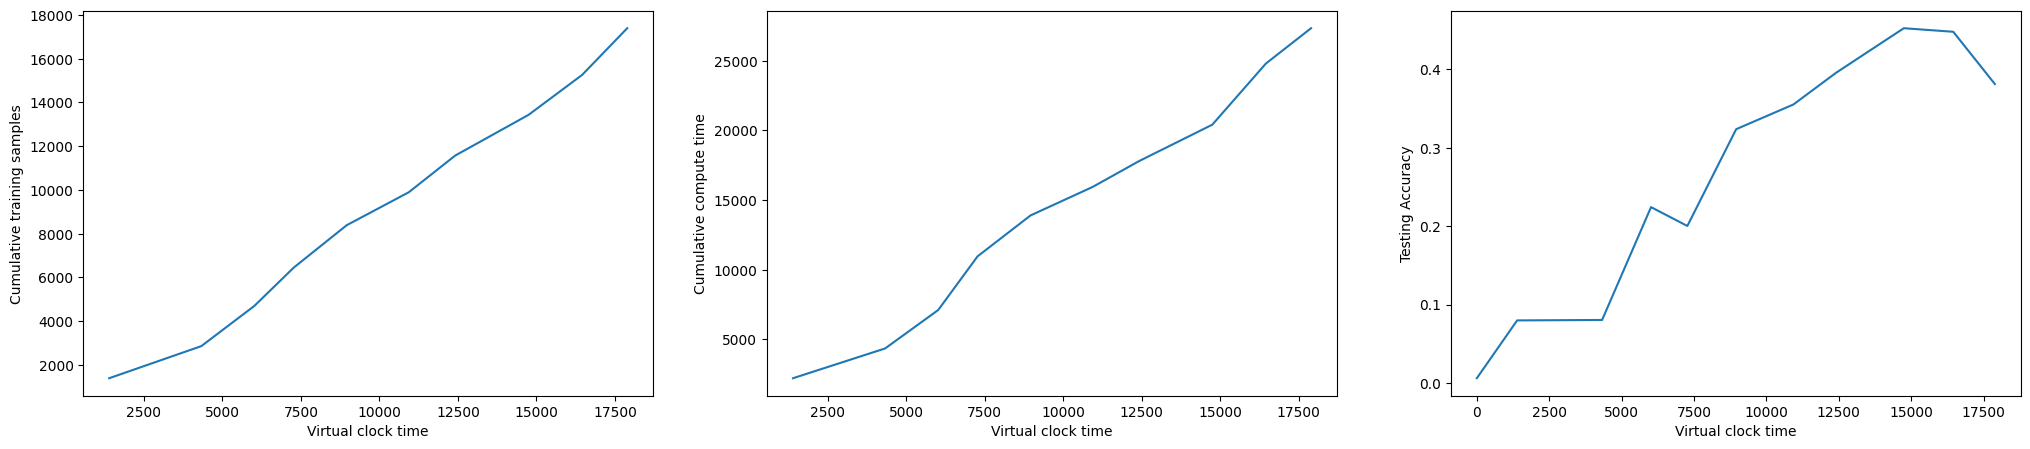

In [49]:
fig,axs =  plt.subplots(1,3,figsize=(25,5))
axs[0].set_ylabel("Cumulative training samples")
axs[0].plot(sync_eval_times[1:],np.cumsum(sync_training_samples_per_round))
axs[1].set_ylabel("Cumulative compute time")
axs[1].plot(sync_eval_times[1:],np.cumsum(sync_compute_units))
axs[2].set_ylabel("Testing Accuracy")
axs[2].plot(sync_eval_times,sync_accuracies)
for a in axs:
  a.set_xlabel("Virtual clock time")
fig.show()